# WINTER

In [2]:
import pandas as pd

In [3]:
data_winter = pd.read_csv('DATASET/SEASON/data_Winter.csv')

In [20]:
data_winter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6419 entries, 0 to 6418
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  6419 non-null   int64  
 1   city_name   6419 non-null   object 
 2   date        6419 non-null   object 
 3   season      6419 non-null   object 
 4   avg_temp_c  6181 non-null   float64
 5   min_temp_c  6142 non-null   float64
 6   max_temp_c  6419 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 351.2+ KB


In [35]:
data_winter

,station_id,city_name,date,season,avg_temp_c,min_temp_c,max_temp_c
0,47662,Tokyo,1951-01-01,Winter,NaN,-3.6,7.0
1,47662,Tokyo,1951-01-02,Winter,NaN,-1.4,8.2
2,47662,Tokyo,1951-01-03,Winter,NaN,-2.2,8.1
3,47662,Tokyo,1951-01-04,Winter,NaN,-1.4,9.2
4,47662,Tokyo,1951-01-05,Winter,NaN,-3.3,9.7
...,...,...,...,...,...,...,...
6414,47662,Tokyo,2023-02-24,Winter,8.9,6.2,11.9
6415,47662,Tokyo,2023-02-25,Winter,7.7,4.3,11.7
6416,47662,Tokyo,2023-02-26,Winter,5.9,2.1,10.1
6417,47662,Tokyo,2023-02-27,Winter,8.5,3.7,13.9


## PREDIKSI 1 HARI

### RNN

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [6]:
# Load data
data = data_winter  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_63756\1044710312.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_63756\1044710312.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [11]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape) 
print("Shape of y:", y.shape) 

Shape of X: (6412, 7, 1)
Shape of y: (6412,)


In [13]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [14]:
# Function to train and evaluate an RNN model
def train_evaluate_rnn_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            model.add(SimpleRNN(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            model.add(SimpleRNN(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))
    
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    
    return rmse, mae, r2

In [15]:
# RNN configurations based on the table provided
rnn_configs = [
    {'hidden_units': [11], 'epochs': 50},
    {'hidden_units': [4, 5], 'epochs': 263},
    {'hidden_units': [5, 7, 3], 'epochs': 92}
]

# Train and evaluate each configuration
results = []
for i, config in enumerate(rnn_configs):
    rmse, mae, r2 = train_evaluate_rnn_model(config['hidden_units'], config['epochs'])
    results.append({'Model': f'RNN {i+1}', 'Hidden Units': config['hidden_units'], 'Epochs': config['epochs'], 'RMSE': rmse, 'MAE': mae, 'R2': r2})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/50

257/257 [==============================] - 2s 3ms/step - loss: 0.0153 - val_loss: 0.0131
Epoch 2/50
257/257 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0131
Epoch 3/50
257/257 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0128
Epoch 4/50
257/257 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0127
Epoch 5/50
257/257 [==============================] - 1s 2ms/step - loss: 0.0133 - val_loss: 0.0126
Epoch 6/50
257/257 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0127
Epoch 7/50
257/257 [==============================] - 1s 2ms/step - loss: 0.0133 - val_loss: 0.0128
Epoch 8/50
257/257 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0127
Epoch 9/50
257/257 [==============================] - 1s 2ms/step - loss: 0.0134 - val_loss: 0.0126
Epoch 10/50
257/257 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.013

In [16]:
results_df

,Model,Hidden Units,Epochs,RMSE,MAE,R2
0,RNN 1,[11],50,2.912240,2.298620,0.253798
1,RNN 2,"[4, 5]",263,2.922438,2.307895,0.248563
2,RNN 3,"[5, 7, 3]",92,2.982284,2.380174,0.217472


In [18]:
results_df.to_csv(f'HASIL/RNN_WINTER.csv', index=False)

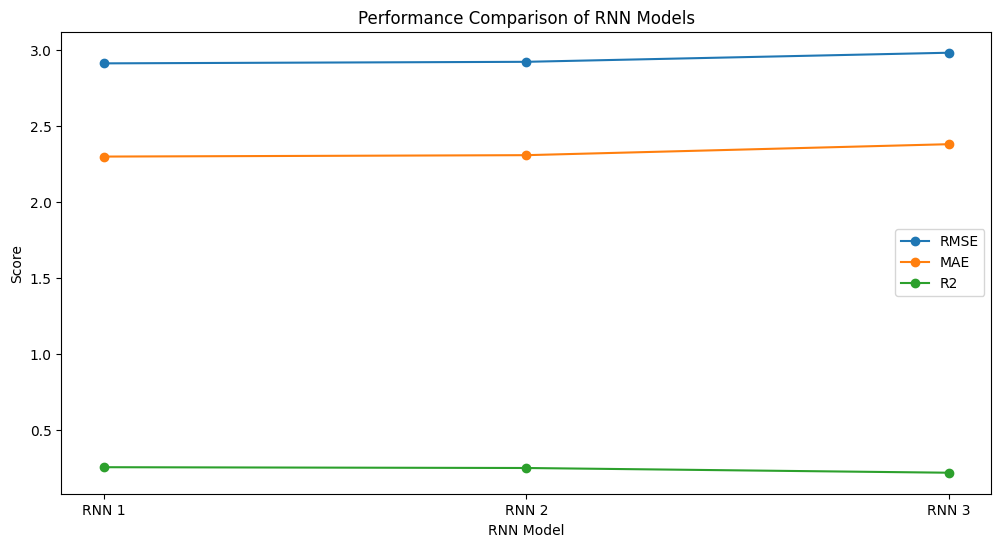

In [17]:
# Optional: Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.xlabel("RNN Model")
plt.ylabel("Score")
plt.title("Performance Comparison of RNN Models")
plt.legend()
plt.show()

### LSTM

In [23]:
from tensorflow.keras.layers import LSTM

In [24]:
# Load data
data = data_winter  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_63756\1044710312.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_63756\1044710312.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [25]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape) 
print("Shape of y:", y.shape) 

Shape of X: (6412, 7, 1)
Shape of y: (6412,)


In [27]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [28]:
def train_evaluate_lstm_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            # First LSTM layer with input shape
            model.add(LSTM(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            # Subsequent LSTM layers
            model.add(LSTM(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))
    
    # Output layer
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    
    return rmse, mae, r2

In [30]:
# LSTM configurations based on the table provided
lstm_configs = [
    {'hidden_units': [10], 'epochs': 20},
    {'hidden_units': [12, 4], 'epochs': 91},
    {'hidden_units': [11, 11, 1], 'epochs': 98}
]

# Train and evaluate each configuration
results = []
for i, config in enumerate(lstm_configs):
    rmse, mae, r2 = train_evaluate_rnn_model(config['hidden_units'], config['epochs'])
    results.append({'Model': f'LSTM {i+1}', 'Hidden Units': config['hidden_units'], 'Epochs': config['epochs'], 'RMSE': rmse, 'MAE': mae, 'R2': r2})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/20
257/257 [==============================] - 2s 4ms/step - loss: 0.0752 - val_loss: 0.0135
Epoch 2/20
257/257 [==============================] - 1s 3ms/step - loss: 0.0144 - val_loss: 0.0135
Epoch 3/20
257/257 [==============================] - 1s 3ms/step - loss: 0.0143 - val_loss: 0.0134
Epoch 4/20
257/257 [==============================] - 1s 3ms/step - loss: 0.0142 - val_loss: 0.0134
Epoch 5/20
257/257 [==============================] - 1s 3ms/step - loss: 0.0141 - val_loss: 0.0133
Epoch 6/20
257/257 [==============================] - 1s 3ms/step - loss: 0.0140 - val_loss: 0.0134
Epoch 7/20
257/257 [==============================] - 1s 3ms/step - loss: 0.0139 - val_loss: 0.0130
Epoch 8/20
257/257 [==============================] - 1s 3ms/step - loss: 0.0138 - val_loss: 0.0129
Epoch 9/20
257/257 [==============================] - 1s 3ms/step - loss: 0.0136 - val_loss: 0.0128
Epoch 10/20
257/257 [==============================] - 1s 5ms/step - loss: 0.0135 - val_loss: 0.0127

In [31]:
results_df

,Model,Hidden Units,Epochs,RMSE,MAE,R2
0,LSTM 1,[10],20,2.887353,2.268372,0.266497
1,LSTM 2,"[12, 4]",91,2.935565,2.317615,0.241797
2,LSTM 3,"[11, 11, 1]",98,3.376096,2.693159,-0.002840


In [32]:
results_df.to_csv(f'HASIL/LSTM_WINTER.csv', index=False)

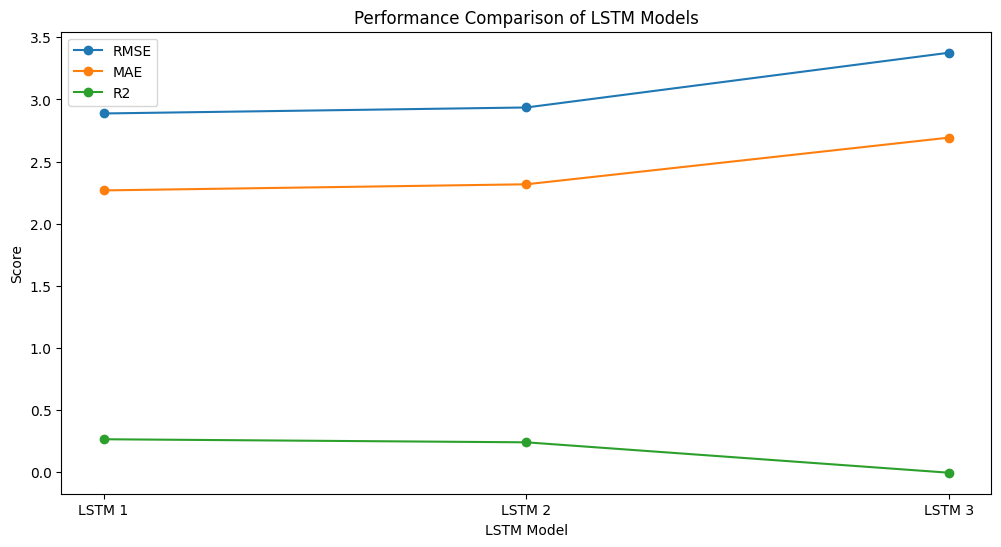

In [33]:
# Optional: Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.xlabel("LSTM Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

### ANN

In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [37]:
# Load data
data = data_winter  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_63756\1044710312.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_63756\1044710312.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [38]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape) 
print("Shape of y:", y.shape) 

Shape of X: (6412, 7, 1)
Shape of y: (6412,)


In [40]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [41]:
# Function to train and evaluate an ANN model
def train_evaluate_ann_model(hidden_units, epochs):
    model = Sequential()
    # Flatten input data to feed into Dense layers
    model.add(Dense(hidden_units[0], activation='relu', input_shape=(X_train.shape[1] * X_train.shape[2],)))
    
    # Add hidden layers based on the configuration
    for units in hidden_units[1:]:
        model.add(Dense(units, activation='relu'))
    
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=Adam(), loss='mse')
    
    # Flatten the input before feeding it to the model
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    # Train the model
    model.fit(X_train_flat, y_train, epochs=epochs, batch_size=16, validation_data=(X_val_flat, y_val), verbose=1)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test_flat)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    
    return rmse, mae, r2

In [42]:
# ANN configurations based on the table provided
ann_configs = [
    {'hidden_units': [8], 'epochs': 161},
    {'hidden_units': [4, 16], 'epochs': 193},
    {'hidden_units': [3, 10, 12], 'epochs': 285}
]

In [43]:
# Train and evaluate each configuration
results = []
for i, config in enumerate(ann_configs):
    rmse, mae, r2 = train_evaluate_ann_model(config['hidden_units'], config['epochs'])
    results.append({'Model': f'ANN {i+1}', 'Hidden Units': config['hidden_units'], 'Epochs': config['epochs'], 'RMSE': rmse, 'MAE': mae, 'R2': r2})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/161
257/257 [==============================] - 1s 3ms/step - loss: 0.0172 - val_loss: 0.0141
Epoch 2/161
257/257 [==============================] - 0s 2ms/step - loss: 0.0144 - val_loss: 0.0134
Epoch 3/161
257/257 [==============================] - 0s 2ms/step - loss: 0.0138 - val_loss: 0.0131
Epoch 4/161
257/257 [==============================] - 0s 2ms/step - loss: 0.0136 - val_loss: 0.0129
Epoch 5/161
257/257 [==============================] - 1s 2ms/step - loss: 0.0135 - val_loss: 0.0129
Epoch 6/161
257/257 [==============================] - 0s 2ms/step - loss: 0.0134 - val_loss: 0.0128
Epoch 7/161
257/257 [==============================] - 0s 2ms/step - loss: 0.0133 - val_loss: 0.0129
Epoch 8/161
257/257 [==============================] - 0s 2ms/step - loss: 0.0133 - val_loss: 0.0128
Epoch 9/161
257/257 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0128
Epoch 10/161
257/257 [==============================] - 0s 2ms/step - loss: 0.0132 - val_lo

In [44]:
results_df

,Model,Hidden Units,Epochs,RMSE,MAE,R2
0,ANN 1,[8],161,2.897909,2.252071,0.261124
1,ANN 2,"[4, 16]",193,2.910707,2.299889,0.254584
2,ANN 3,"[3, 10, 12]",285,2.906482,2.280585,0.256746


In [45]:
results_df.to_csv(f'HASIL/ANN_WINTER.csv', index=False)

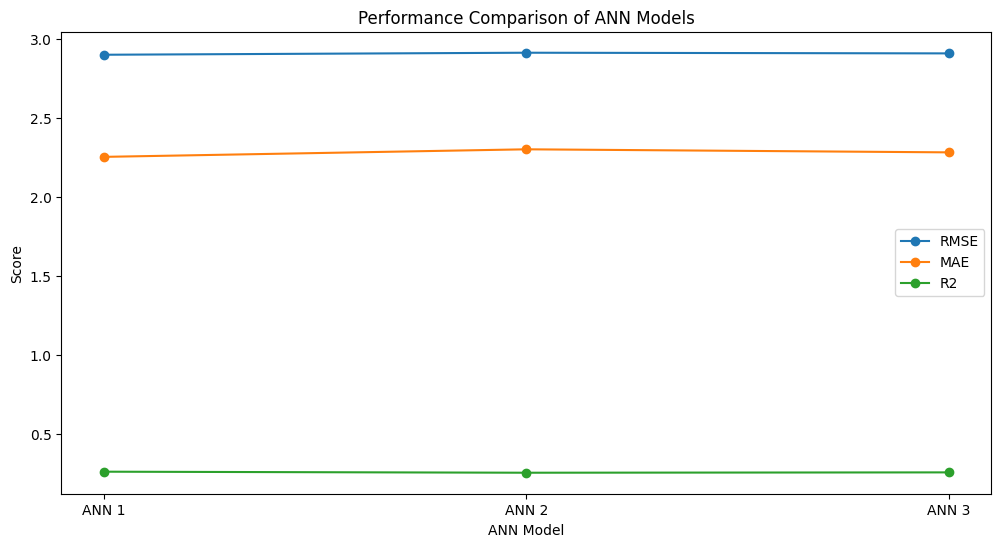

In [46]:
# Optional: Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.xlabel("ANN Model")
plt.ylabel("Score")
plt.title("Performance Comparison of ANN Models")
plt.legend()
plt.show()

## PREDIKSI 15 HARI

### RNN

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [5]:
# Load data
data = data_winter  # Pastikan `data_winter` sudah dimuat sebagai DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_54296\1740994759.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_54296\1740994759.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
def create_sequences(data, target, sequence_length=26, predict_days=15):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        # Create sequence with lag
        sequences.append(data[i:i + sequence_length].reshape(-1, 1)) 
        
        # Simulate prediction for the next 15 days (lag of 26)
        labels.append(np.nan)

        # Simulate prediction: use the average of the last two values in the sequence
        last_two_values = data[i + sequence_length - 2:i + sequence_length] 
        avg_last_two_values = np.mean(last_two_values)
        
        labels[-1] = avg_last_two_values
    
    return np.array(sequences), np.array(labels)

In [ ]:
# Create sequences and target
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=26)

# Check shapes of X and y
print("Shape of X:", X.shape) 
print("Shape of y:", y.shape) 

Shape of X: (6393, 26, 1)
Shape of y: (6393,)


In [8]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [9]:
# Function to train and evaluate an RNN model
def train_evaluate_rnn_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            model.add(SimpleRNN(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            model.add(SimpleRNN(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))
    
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    
    return rmse, mae, r2, model

In [ ]:
def predict_next_15_days(model, last_sequence, days=15):
    predictions = []
    current_input = last_sequence  # Start with the last available sequence
    
    for _ in range(days):
        # Predict the next day (model expects input in 3D: batch_size, sequence_length, features)
        pred = model.predict(current_input.reshape(1, current_input.shape[0], 1))
        
        predictions.append(pred[0, 0]) 
        
        # Update the sequence by removing the first value and adding the predicted value at the end
        current_input = np.append(current_input[1:], pred) 
        
        # Ensure the new sequence shape is correct for the next prediction
        current_input = current_input.reshape(-1, 1) 
    
    # Rescale the predictions back to the original scale
    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_rescaled

In [11]:
# Define list containing different configurations for evaluation purposes
rnn_configs = [
    {'hidden_units': [11], 'epochs': 50},
    {'hidden_units': [4, 5], 'epochs': 263},
    {'hidden_units': [5, 7, 3], 'epochs': 92}
]

results = []

# Train and evaluate each configuration
for i, config in enumerate(rnn_configs):
    # Train and evaluate the model
    rmse, mae, r2, model = train_evaluate_rnn_model(config['hidden_units'], config['epochs'])
    
    # Append evaluation results to the list
    results.append({
        'Model': f'RNN {i+1}',
        'Hidden Units': config['hidden_units'],
        'Epochs': config['epochs'],
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Model_Object': model  # Save the model object for the best configuration
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("Evaluation Results:")
print(results_df)



Epoch 1/50

256/256 [==============================] - 2s 5ms/step - loss: 0.2390 - val_loss: 0.0042
Epoch 2/50
256/256 [==============================] - 1s 4ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 3/50
256/256 [==============================] - 1s 4ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 4/50
256/256 [==============================] - 1s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/50
256/256 [==============================] - 1s 4ms/step - loss: 8.3102e-04 - val_loss: 6.6900e-04
Epoch 6/50
256/256 [==============================] - 1s 3ms/step - loss: 5.2220e-04 - val_loss: 4.1704e-04
Epoch 7/50
256/256 [==============================] - 1s 4ms/step - loss: 3.2582e-04 - val_loss: 2.4850e-04
Epoch 8/50
256/256 [==============================] - 1s 4ms/step - loss: 1.8125e-04 - val_loss: 1.1481e-04
Epoch 9/50
256/256 [==============================] - 1s 5ms/step - loss: 8.7590e-05 - val_loss: 4.8546e-05
Epoch 10/50
256/256 [==============================] - 1s 

In [12]:
results_df

,Model,Hidden Units,Epochs,RMSE,MAE,R2,Model_Object
0,RNN 1,[11],50,0.011773,0.011258,0.999983,<keras.src.engine.sequential.Sequential object...
1,RNN 2,"[4, 5]",263,2.846321,2.235603,-0.000930,<keras.src.engine.sequential.Sequential object...
2,RNN 3,"[5, 7, 3]",92,0.009468,0.004075,0.999989,<keras.src.engine.sequential.Sequential object...


In [14]:
results_df.to_csv(f'HASIL/15_RNN_WINTER.csv', index=False)

In [13]:
# Select the best model based on RMSE (lowest RMSE indicates best model)
best_model_index = results_df['RMSE'].idxmin()
best_model_info = results_df.iloc[best_model_index]
best_model = best_model_info['Model_Object']  # Retrieve the best model object

print("\nBest Model Configuration:")
print(best_model_info[['Model', 'Hidden Units', 'Epochs', 'RMSE', 'MAE', 'R2']])

# Use the best model to predict the next 15 days
last_sequence = X_test[-1]  # Use the last sequence from the test set
predictions_rescaled = predict_next_15_days(best_model, last_sequence)  # Get 15-day predictions

# Display the predictions
print("\nPredictions for the next 15 days using the best model:")
print(predictions_rescaled.flatten())


Best Model Configuration:
Model               RNN 3
Hidden Units    [5, 7, 3]
Epochs                 92
RMSE             0.009468
MAE              0.004075
R2               0.999989
Name: 2, dtype: object
1/1 [==============================] - 0s 26ms/step

Predictions for the next 15 days using the best model:
[7.85261   8.124228  7.9912295 8.055804  8.017657  8.039765  8.0253525
 8.034919  8.027334  8.031043  8.028585  8.028962  8.028183  8.02774
 8.027413 ]


In [15]:
predictions_rescaled

array([[7.85261  ],
       [8.124228 ],
       [7.9912295],
       [8.055804 ],
       [8.017657 ],
       [8.039765 ],
       [8.0253525],
       [8.034919 ],
       [8.027334 ],
       [8.031043 ],
       [8.028585 ],
       [8.028962 ],
       [8.028183 ],
       [8.02774  ],
       [8.027413 ]], dtype=float32)

In [16]:
# Ubah menjadi DataFrame
df_predictions = pd.DataFrame(predictions_rescaled, columns=['Predicted_Value'])

In [17]:
df_predictions

,Predicted_Value
0,7.852610
1,8.124228
2,7.991230
3,8.055804
4,8.017657
5,8.039765
6,8.025352
7,8.034919
8,8.027334
9,8.031043


In [18]:
df_predictions.to_csv(f'HASIL_PREDICT/15_RNN_WINTER.csv', index=False)

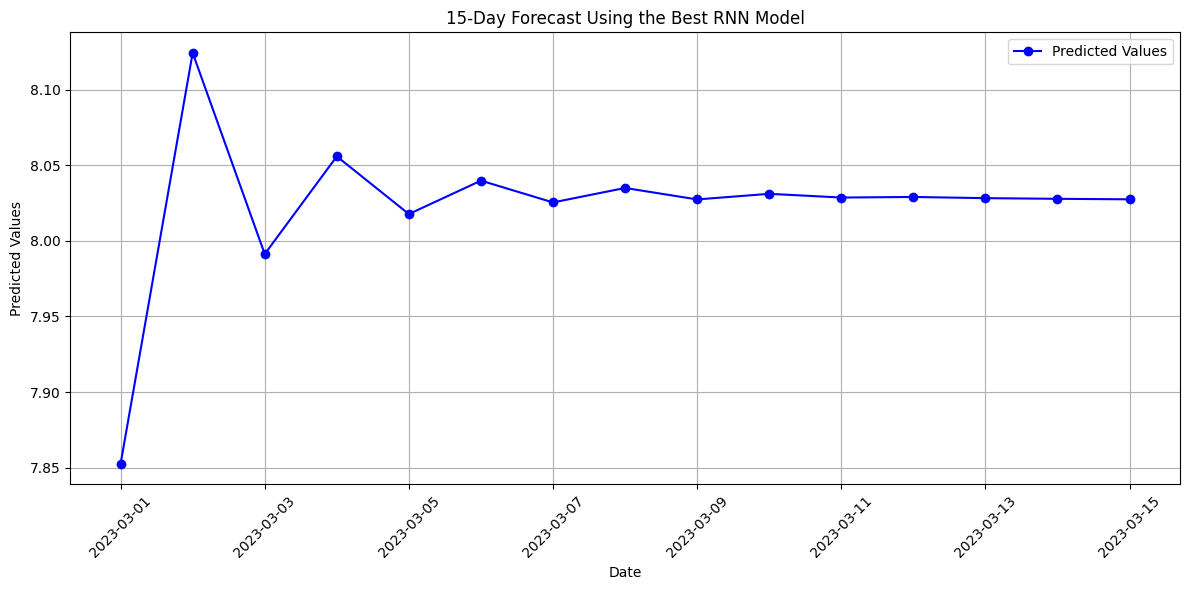

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Generate dates for the next 15 days for plotting purposes
from datetime import timedelta

last_date = pd.to_datetime(data_winter['date'].iloc[-1])  # Ambil tanggal terakhir dari data asli
future_dates = [last_date + timedelta(days=i) for i in range(1, 16)]

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions_rescaled.flatten(), marker='o', color='b', label='Predicted Values')
plt.title('15-Day Forecast Using the Best RNN Model')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

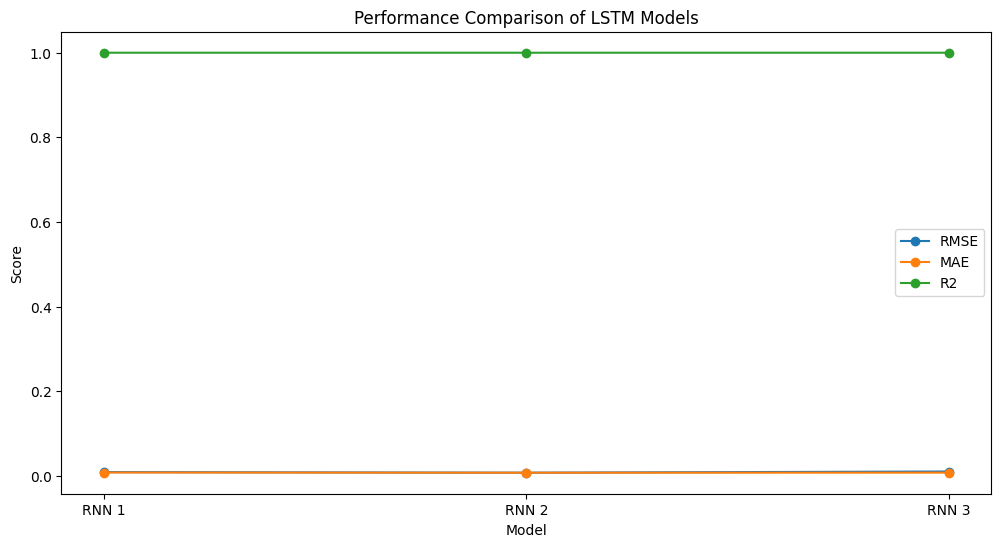

In [25]:
# Optional plotting of results
plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

### LSTM

In [85]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [86]:
# Load data
data = data_winter  # Pastikan `data_winter` sudah dimuat sebagai DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_63756\1740994759.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_63756\1740994759.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [87]:
def create_sequences(data, target, sequence_length=25, predict_days=15):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        # Create sequence with lag
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        
        # Simulate prediction for the next 15 days (lag of 25)
        labels.append(np.nan)  # Placeholder for actual label (for the time being, we'll calculate it)

        # Simulate prediction: use the average of the last two values in the sequence
        last_two_values = data[i + sequence_length - 2:i + sequence_length]  # Last two values of the sequence
        avg_last_two_values = np.mean(last_two_values)
        
        # Add the simulated prediction to labels (this will be used as the "prediction" for the future)
        labels[-1] = avg_last_two_values
    
    return np.array(sequences), np.array(labels)

In [ ]:
# Create sequences and target
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=25)

# Check shapes of X and y
print("Shape of X:", X.shape) 
print("Shape of y:", y.shape)

Shape of X: (6394, 25, 1)
Shape of y: (6394,)


In [89]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [104]:
def train_evaluate_lstm_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            # First LSTM layer with input shape
            model.add(LSTM(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            # Subsequent LSTM layers
            model.add(LSTM(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))
    
    # Output layer
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    
    # Return RMSE, MAE, R2, and model
    return rmse, mae, r2, model


In [ ]:
def predict_next_15_days(model, last_sequence, days=15):
    predictions = []
    current_input = last_sequence  # Start with the last available sequence
    
    for _ in range(days):
        # Predict the next day (model expects input in 3D: batch_size, sequence_length, features)
        pred = model.predict(current_input.reshape(1, current_input.shape[0], 1))
        
        predictions.append(pred[0, 0])  # Append the scalar prediction value
        
        # Update the sequence by removing the first value and adding the predicted value at the end
        current_input = np.append(current_input[1:], pred)
        
        # Ensure the new sequence shape is correct for the next prediction
        current_input = current_input.reshape(-1, 1) 
    
    # Rescale the predictions back to the original scale
    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_rescaled

In [111]:
# Define list containing different configurations for evaluation purposes
lstm_configs = [
    {'hidden_units': [10], 'epochs': 20},
    {'hidden_units': [12, 4], 'epochs': 91},
    {'hidden_units': [11, 11, 1], 'epochs': 98}
]

results = []

# Train and evaluate each configuration
for i, config in enumerate(lstm_configs):
    # Train and evaluate the model
    rmse, mae, r2, model = train_evaluate_lstm_model(config['hidden_units'], config['epochs'])
    
    # Append evaluation results to the list
    results.append({
        'Model': f'LSTM {i+1}',
        'Hidden Units': config['hidden_units'],
        'Epochs': config['epochs'],
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Model_Object': model  # Save the model object for the best configuration
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("Evaluation Results:")
print(results_df)


Epoch 1/20
256/256 [==============================] - 5s 11ms/step - loss: 0.0422 - val_loss: 0.0073
Epoch 2/20
256/256 [==============================] - 2s 8ms/step - loss: 0.0061 - val_loss: 0.0048
Epoch 3/20
256/256 [==============================] - 2s 9ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 4/20
256/256 [==============================] - 3s 13ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 5/20
256/256 [==============================] - 3s 10ms/step - loss: 9.3630e-04 - val_loss: 6.2176e-04
Epoch 6/20
256/256 [==============================] - 2s 8ms/step - loss: 5.9744e-04 - val_loss: 4.9366e-04
Epoch 7/20
256/256 [==============================] - 2s 7ms/step - loss: 4.6234e-04 - val_loss: 3.9792e-04
Epoch 8/20
256/256 [==============================] - 2s 7ms/step - loss: 3.8718e-04 - val_loss: 3.3499e-04
Epoch 9/20
256/256 [==============================] - 2s 7ms/step - loss: 3.3015e-04 - val_loss: 2.8765e-04
Epoch 10/20
256/256 [==============================] - 2s

In [112]:
results_df

,Model,Hidden Units,Epochs,RMSE,MAE,R2,Model_Object
0,LSTM 1,[10],20,0.043554,0.033979,0.999759,<keras.src.engine.sequential.Sequential object...
1,LSTM 2,"[12, 4]",91,0.041490,0.031877,0.999781,<keras.src.engine.sequential.Sequential object...
2,LSTM 3,"[11, 11, 1]",98,2.806857,2.220786,-0.000347,<keras.src.engine.sequential.Sequential object...


In [113]:
results_df.to_csv(f'HASIL/15_LSTM_WINTER.csv', index=False)

In [114]:
# Select the best model based on RMSE (lowest RMSE indicates best model)
best_model_index = results_df['RMSE'].idxmin()
best_model_info = results_df.iloc[best_model_index]
best_model = best_model_info['Model_Object']  # Retrieve the best model object

print("\nBest Model Configuration:")
print(best_model_info[['Model', 'Hidden Units', 'Epochs', 'RMSE', 'MAE', 'R2']])

# Use the best model to predict the next 15 days
last_sequence = X_test[-1]  # Use the last sequence from the test set
predictions_rescaled = predict_next_15_days(best_model, last_sequence)  # Get 15-day predictions

# Display the predictions
print("\nPredictions for the next 15 days using the best model:")
print(predictions_rescaled.flatten())


Best Model Configuration:
Model             LSTM 2
Hidden Units     [12, 4]
Epochs                91
RMSE             0.04149
MAE             0.031877
R2              0.999781
Name: 1, dtype: object
1/1 [==============================] - 0s 28ms/step

Predictions for the next 15 days using the best model:
[14.929795  14.858264  14.909451  14.896449  14.924283  14.931254
 14.944196  14.954317  14.964445  14.973204  14.981665  14.987951
 14.993435  14.9977045 15.002039 ]


In [115]:
predictions_rescaled

array([[14.929795 ],
       [14.858264 ],
       [14.909451 ],
       [14.896449 ],
       [14.924283 ],
       [14.931254 ],
       [14.944196 ],
       [14.954317 ],
       [14.964445 ],
       [14.973204 ],
       [14.981665 ],
       [14.987951 ],
       [14.993435 ],
       [14.9977045],
       [15.002039 ]], dtype=float32)

In [122]:
# Ubah menjadi DataFrame
df_predictions = pd.DataFrame(predictions_rescaled, columns=['Predicted_Value'])

In [123]:
df_predictions

,Predicted_Value
0,14.929795
1,14.858264
2,14.909451
3,14.896449
4,14.924283
5,14.931254
6,14.944196
7,14.954317
8,14.964445
9,14.973204


In [124]:
df_predictions.to_csv(f'HASIL_PREDICT/15_LSTM_WINTER.csv', index=False)

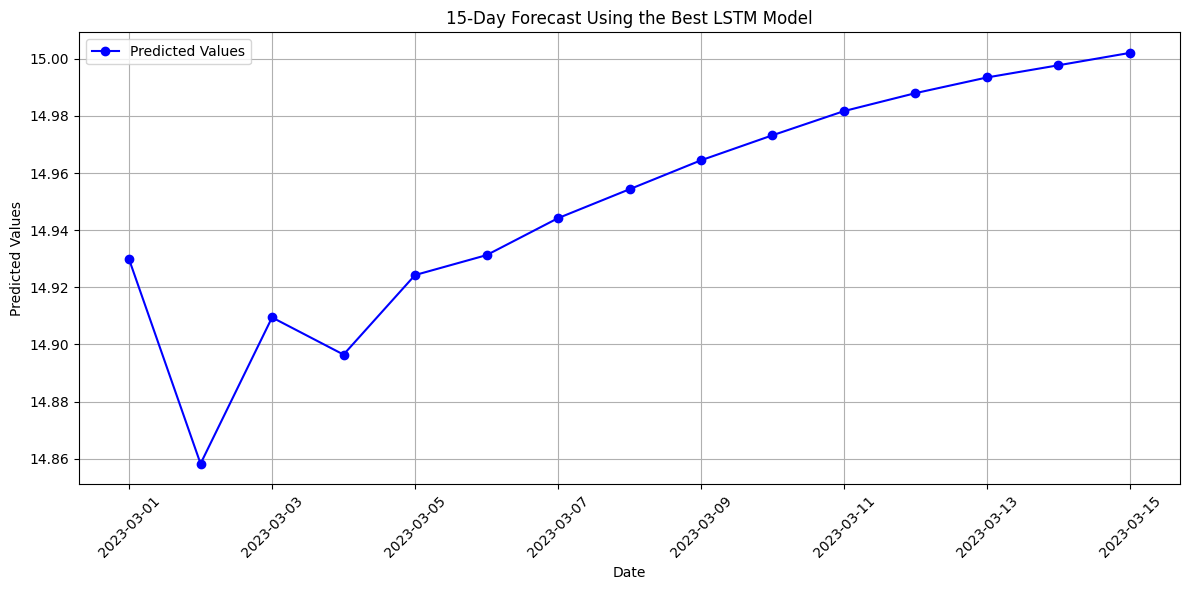

In [120]:
import matplotlib.pyplot as plt
import numpy as np

# Generate dates for the next 15 days for plotting purposes
from datetime import timedelta

last_date = pd.to_datetime(data_winter['date'].iloc[-1])  # Ambil tanggal terakhir dari data asli
future_dates = [last_date + timedelta(days=i) for i in range(1, 16)]

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions_rescaled.flatten(), marker='o', color='b', label='Predicted Values')
plt.title('15-Day Forecast Using the Best LSTM Model')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

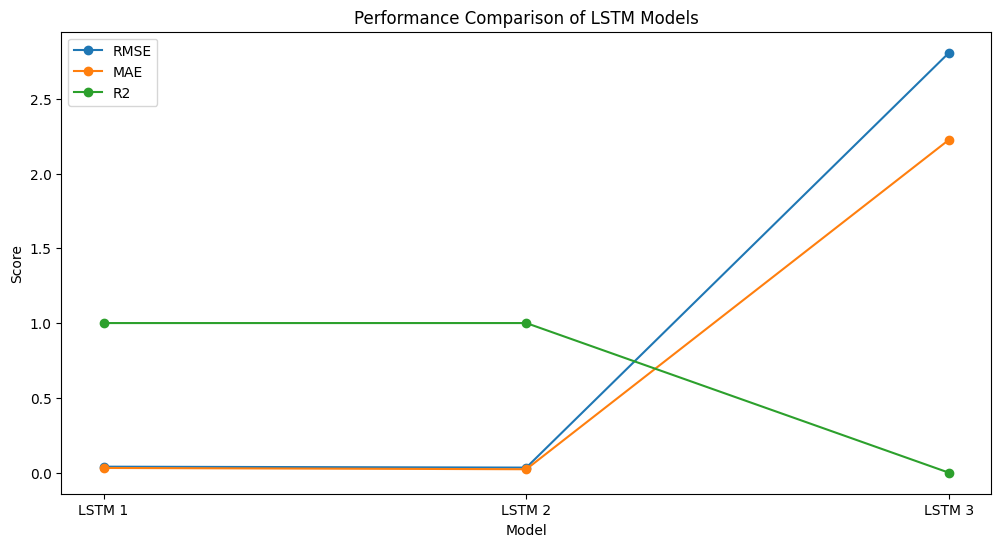

In [101]:
# Optional plotting of results
plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

### ANN

In [66]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [67]:
# Load data
data = data_winter  # Pastikan `data_winter` sudah dimuat sebagai DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1740994759.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1740994759.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
def create_sequences(data, target, sequence_length=19, predict_days=15):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        # Create sequence with lag
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        
        # Simulate prediction for the next 15 days (lag of 19)
        labels.append(np.nan) 

        # Simulate prediction: use the average of the last two values in the sequence
        last_two_values = data[i + sequence_length - 2:i + sequence_length] 
        avg_last_two_values = np.mean(last_two_values)
        
        # Add the simulated prediction to labels (this will be used as the "prediction" for the future)
        labels[-1] = avg_last_two_values
    
    return np.array(sequences), np.array(labels)

In [ ]:
# Create sequences and target
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=19)

# Check shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (6400, 19, 1)
Shape of y: (6400,)


In [70]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [71]:
# Function to train and evaluate an ANN model
def train_evaluate_ann_model(hidden_units, epochs):
    model = Sequential()
    # Flatten input data to feed into Dense layers
    model.add(Dense(hidden_units[0], activation='relu', input_shape=(X_train.shape[1] * X_train.shape[2],)))
    
    # Add hidden layers based on the configuration
    for units in hidden_units[1:]:
        model.add(Dense(units, activation='relu'))
    
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=Adam(), loss='mse')
    
    # Flatten the input before feeding it to the model
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    # Train the model
    model.fit(X_train_flat, y_train, epochs=epochs, batch_size=16, validation_data=(X_val_flat, y_val), verbose=1)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test_flat)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    
    return rmse, mae, r2, model

In [72]:
last_sequence = X_test[-1].reshape(1, -1)

In [ ]:
def predict_next_15_days(model, last_sequence, days=15):
    predictions = []
    current_input = last_sequence.flatten() 

    for _ in range(days):
        # Predict the next day using the flattened input
        pred = model.predict(current_input.reshape(1, -1))  
        
        predictions.append(pred[0, 0]) 
        
        # Update the sequence by removing the first value and adding the predicted value at the end
        current_input = np.append(current_input[1:], pred)
        
    # Rescale the predictions back to the original scale
    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_rescaled


In [74]:
# Define list containing different configurations for evaluation purposes
ann_configs = [
    {'hidden_units': [8], 'epochs': 161},
    {'hidden_units': [4, 16], 'epochs': 193},
    {'hidden_units': [3, 10, 12], 'epochs': 285}
]

results = []

# Train and evaluate each configuration
for i, config in enumerate(ann_configs):
    # Train and evaluate the model
    rmse, mae, r2, model = train_evaluate_ann_model(config['hidden_units'], config['epochs'])
    
    # Append evaluation results to the list
    results.append({
        'Model': f'ANN {i+1}',
        'Hidden Units': config['hidden_units'],
        'Epochs': config['epochs'],
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Model_Object': model  # Save the model object for the best configuration
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("Evaluation Results:")
print(results_df)


Epoch 1/161
256/256 [==============================] - 2s 3ms/step - loss: 0.1013 - val_loss: 0.0278
Epoch 2/161
256/256 [==============================] - 1s 2ms/step - loss: 0.0229 - val_loss: 0.0186
Epoch 3/161
256/256 [==============================] - 1s 3ms/step - loss: 0.0149 - val_loss: 0.0121
Epoch 4/161
256/256 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.0079
Epoch 5/161
256/256 [==============================] - 1s 2ms/step - loss: 0.0060 - val_loss: 0.0049
Epoch 6/161
256/256 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 7/161
256/256 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 8/161
256/256 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 9/161
256/256 [==============================] - 0s 2ms/step - loss: 8.0179e-04 - val_loss: 7.7637e-04
Epoch 10/161
256/256 [==============================] - 1s 3ms/step - loss: 4.4598e

In [75]:
results_df

,Model,Hidden Units,Epochs,RMSE,MAE,R2,Model_Object
0,ANN 1,[8],161,0.030263,0.003335,0.999882,<keras.src.engine.sequential.Sequential object...
1,ANN 2,"[4, 16]",193,0.039436,0.030050,0.999799,<keras.src.engine.sequential.Sequential object...
2,ANN 3,"[3, 10, 12]",285,0.000626,0.000557,1.000000,<keras.src.engine.sequential.Sequential object...


In [76]:
results_df.to_csv(f'HASIL/15_ANN_WINTER.csv', index=False)

In [77]:
# Select the best model based on RMSE (lowest RMSE indicates best model)
best_model_index = results_df['RMSE'].idxmin()
best_model_info = results_df.iloc[best_model_index]
best_model = best_model_info['Model_Object']  # Retrieve the best model object

print("\nBest Model Configuration:")
print(best_model_info[['Model', 'Hidden Units', 'Epochs', 'RMSE', 'MAE', 'R2']])

# Use the best model to predict the next 15 days
last_sequence = X_test[-1]  # Use the last sequence from the test set
predictions_rescaled = predict_next_15_days(best_model, last_sequence)  # Get 15-day predictions

# Display the predictions
print("\nPredictions for the next 15 days using the best model:")
print(predictions_rescaled.flatten())


Best Model Configuration:
Model                 ANN 3
Hidden Units    [3, 10, 12]
Epochs                  285
RMSE               0.000626
MAE                0.000557
R2                      1.0
Name: 2, dtype: object
1/1 [==============================] - 0s 38ms/step

Predictions for the next 15 days using the best model:
[14.050894  14.626416  14.339779  14.483815  14.412538  14.449043
 14.431726  14.441111  14.437006  14.439961  14.439222  14.4405155
 14.440839  14.44144   14.4422455]


In [78]:
predictions_rescaled

array([[14.050894 ],
       [14.626416 ],
       [14.339779 ],
       [14.483815 ],
       [14.412538 ],
       [14.449043 ],
       [14.431726 ],
       [14.441111 ],
       [14.437006 ],
       [14.439961 ],
       [14.439222 ],
       [14.4405155],
       [14.440839 ],
       [14.44144  ],
       [14.4422455]], dtype=float32)

In [79]:
# Ubah menjadi DataFrame
df_predictions = pd.DataFrame(predictions_rescaled, columns=['Predicted_Value'])

In [80]:
df_predictions

,Predicted_Value
0,14.050894
1,14.626416
2,14.339779
3,14.483815
4,14.412538
5,14.449043
6,14.431726
7,14.441111
8,14.437006
9,14.439961


In [81]:
df_predictions.to_csv(f'HASIL_PREDICT/15_ANN_WINTER.csv', index=False)

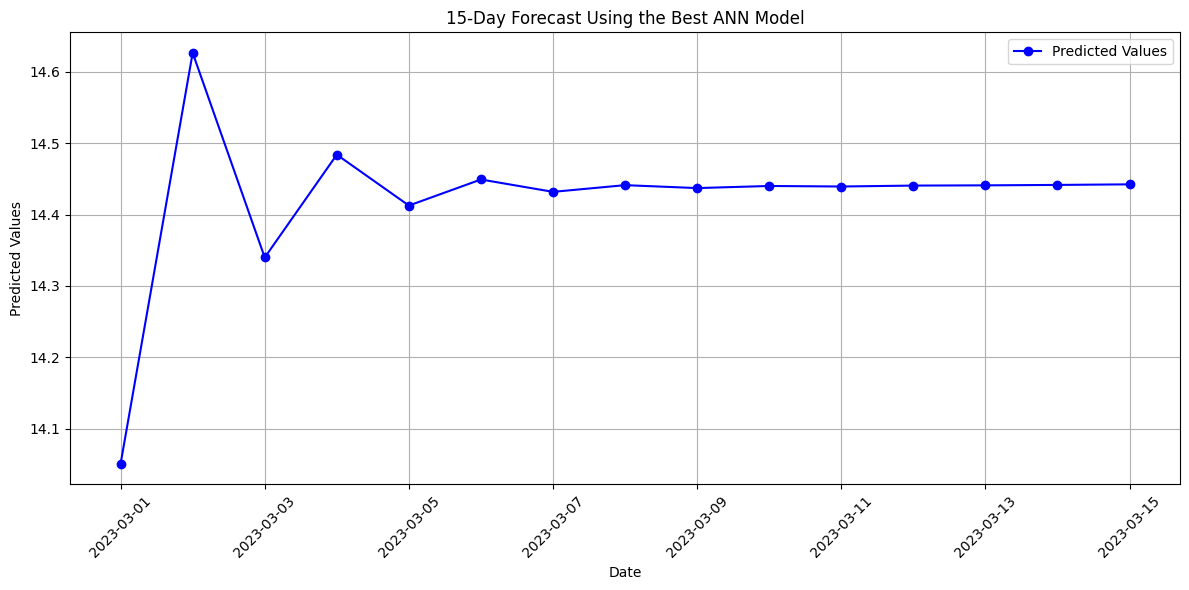

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Generate dates for the next 15 days for plotting purposes
from datetime import timedelta

last_date = pd.to_datetime(data_winter['date'].iloc[-1])  # Ambil tanggal terakhir dari data asli
future_dates = [last_date + timedelta(days=i) for i in range(1, 16)]

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions_rescaled.flatten(), marker='o', color='b', label='Predicted Values')
plt.title('15-Day Forecast Using the Best ANN Model')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

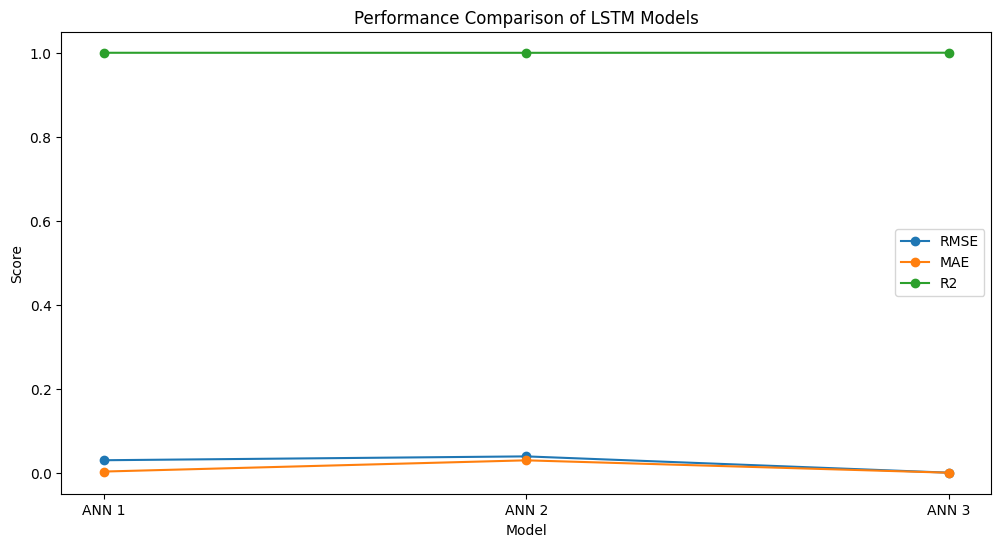

In [83]:
# Optional plotting of results
plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

# SPRING

In [1]:
import pandas as pd
data_spring = pd.read_csv('DATASET/SEASON/data_Spring.csv')
data_spring.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6568 entries, 0 to 6567
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  6568 non-null   int64  
 1   city_name   6568 non-null   object 
 2   date        6568 non-null   object 
 3   season      6568 non-null   object 
 4   avg_temp_c  6361 non-null   float64
 5   min_temp_c  6330 non-null   float64
 6   max_temp_c  6568 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 359.3+ KB


In [36]:
data_spring

,station_id,city_name,date,season,avg_temp_c,min_temp_c,max_temp_c
0,47662,Tokyo,1951-03-01,Spring,NaN,6.5,15.0
1,47662,Tokyo,1951-03-02,Spring,NaN,5.6,11.3
2,47662,Tokyo,1951-03-03,Spring,NaN,2.5,8.2
3,47662,Tokyo,1951-03-04,Spring,NaN,-0.4,9.0
4,47662,Tokyo,1951-03-05,Spring,NaN,-1.1,9.2
...,...,...,...,...,...,...,...
6563,47662,Tokyo,2023-05-27,Spring,21.1,16.9,26.0
6564,47662,Tokyo,2023-05-28,Spring,21.5,18.6,24.4
6565,47662,Tokyo,2023-05-29,Spring,20.0,19.0,21.5
6566,47662,Tokyo,2023-05-30,Spring,21.2,18.8,24.9


## PREDIKSI 1 HARI

### RNN

In [55]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [56]:
# Load data
data = data_spring  # Assuming data_spring is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_100324\466734098.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_100324\466734098.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [57]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape) 
print("Shape of y:", y.shape) 

Shape of X: (6561, 7, 1)
Shape of y: (6561,)


In [59]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [60]:
# Function to train and evaluate an RNN model
def train_evaluate_rnn_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            model.add(SimpleRNN(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            model.add(SimpleRNN(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))
    
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    
    return rmse, mae, r2

In [61]:
# RNN configurations based on the table provided
rnn_configs = [
    {'hidden_units': [5], 'epochs': 104},
    {'hidden_units': [1, 10], 'epochs': 156},
    {'hidden_units': [4, 4, 7], 'epochs': 204}
]

# Train and evaluate each configuration
results = []
for i, config in enumerate(rnn_configs):
    rmse, mae, r2 = train_evaluate_rnn_model(config['hidden_units'], config['epochs'])
    results.append({'Model': f'RNN {i+1}', 'Hidden Units': config['hidden_units'], 'Epochs': config['epochs'], 'RMSE': rmse, 'MAE': mae, 'R2': r2})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/104
263/263 [==============================] - 2s 4ms/step - loss: 0.2328 - val_loss: 0.1245
Epoch 2/104
263/263 [==============================] - 1s 3ms/step - loss: 0.0850 - val_loss: 0.0539
Epoch 3/104
263/263 [==============================] - 1s 3ms/step - loss: 0.0436 - val_loss: 0.0355
Epoch 4/104
263/263 [==============================] - 1s 3ms/step - loss: 0.0342 - val_loss: 0.0326
Epoch 5/104
263/263 [==============================] - 1s 3ms/step - loss: 0.0329 - val_loss: 0.0324
Epoch 6/104
263/263 [==============================] - 1s 3ms/step - loss: 0.0327 - val_loss: 0.0324
Epoch 7/104
263/263 [==============================] - 1s 3ms/step - loss: 0.0328 - val_loss: 0.0324
Epoch 8/104
263/263 [==============================] - 1s 4ms/step - loss: 0.0327 - val_loss: 0.0324
Epoch 9/104
263/263 [==============================] - 1s 3ms/step - loss: 0.0328 - val_loss: 0.0324
Epoch 10/104
263/263 [==============================] - 1s 3ms/step - loss: 0.0328 - val_lo

In [62]:
results_df

,Model,Hidden Units,Epochs,RMSE,MAE,R2
0,RNN 1,[5],104,5.460967,4.545963,-0.001070
1,RNN 2,"[1, 10]",156,3.638693,2.850179,0.555557
2,RNN 3,"[4, 4, 7]",204,3.582440,2.747652,0.569192


In [63]:
results_df.to_csv(f'HASIL/RNN_SPRING.csv', index=False)

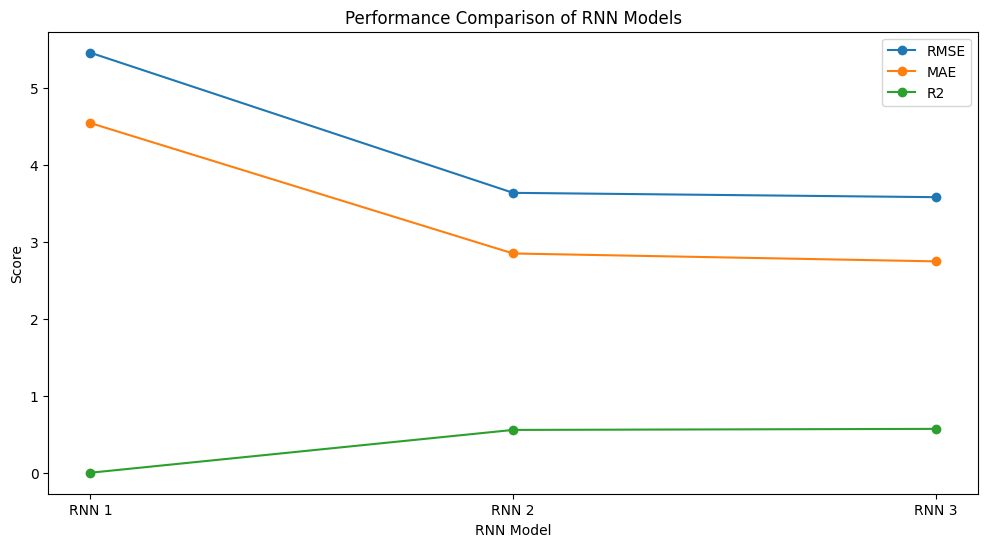

In [64]:
# Optional: Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.xlabel("RNN Model")
plt.ylabel("Score")
plt.title("Performance Comparison of RNN Models")
plt.legend()
plt.show()

### LSTM

In [85]:
from tensorflow.keras.layers import LSTM

In [86]:
# Load data
data = data_spring  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1706446326.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1706446326.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [87]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape) 
print("Shape of y:", y.shape) 

Shape of X: (6561, 7, 1)
Shape of y: (6561,)


In [89]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [90]:
def train_evaluate_lstm_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            # First LSTM layer with input shape
            model.add(LSTM(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            # Subsequent LSTM layers
            model.add(LSTM(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))
    
    # Output layer
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    
    return rmse, mae, r2

In [91]:
# LSTM configurations based on the table provided
lstm_configs = [
    {'hidden_units': [3], 'epochs': 273},
    {'hidden_units': [3, 20], 'epochs': 285},
    {'hidden_units': [6, 11, 18], 'epochs': 280}
]

# Train and evaluate each configuration
results = []
for i, config in enumerate(lstm_configs):
    rmse, mae, r2 = train_evaluate_rnn_model(config['hidden_units'], config['epochs'])
    results.append({'Model': f'LSTM {i+1}', 'Hidden Units': config['hidden_units'], 'Epochs': config['epochs'], 'RMSE': rmse, 'MAE': mae, 'R2': r2})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/273
263/263 [==============================] - 3s 6ms/step - loss: 0.1086 - val_loss: 0.0168
Epoch 2/273
263/263 [==============================] - 1s 5ms/step - loss: 0.0160 - val_loss: 0.0153
Epoch 3/273
263/263 [==============================] - 1s 5ms/step - loss: 0.0155 - val_loss: 0.0149
Epoch 4/273
263/263 [==============================] - 1s 5ms/step - loss: 0.0154 - val_loss: 0.0148
Epoch 5/273
263/263 [==============================] - 1s 4ms/step - loss: 0.0153 - val_loss: 0.0146
Epoch 6/273
263/263 [==============================] - 1s 4ms/step - loss: 0.0153 - val_loss: 0.0147
Epoch 7/273
263/263 [==============================] - 1s 4ms/step - loss: 0.0152 - val_loss: 0.0144
Epoch 8/273
263/263 [==============================] - 1s 4ms/step - loss: 0.0152 - val_loss: 0.0145
Epoch 9/273
263/263 [==============================] - 1s 5ms/step - loss: 0.0152 - val_loss: 0.0145
Epoch 10/273
263/263 [==============================] - 1s 5ms/step - loss: 0.0151 - val_lo

In [92]:
results_df

,Model,Hidden Units,Epochs,RMSE,MAE,R2
0,LSTM 1,[3],273,3.600587,2.809225,0.564817
1,LSTM 2,"[3, 20]",285,3.739734,2.883232,0.530531
2,LSTM 3,"[6, 11, 18]",280,3.696644,2.837211,0.541287


In [93]:
results_df.to_csv(f'HASIL/LSTM_SPRING.csv', index=False)

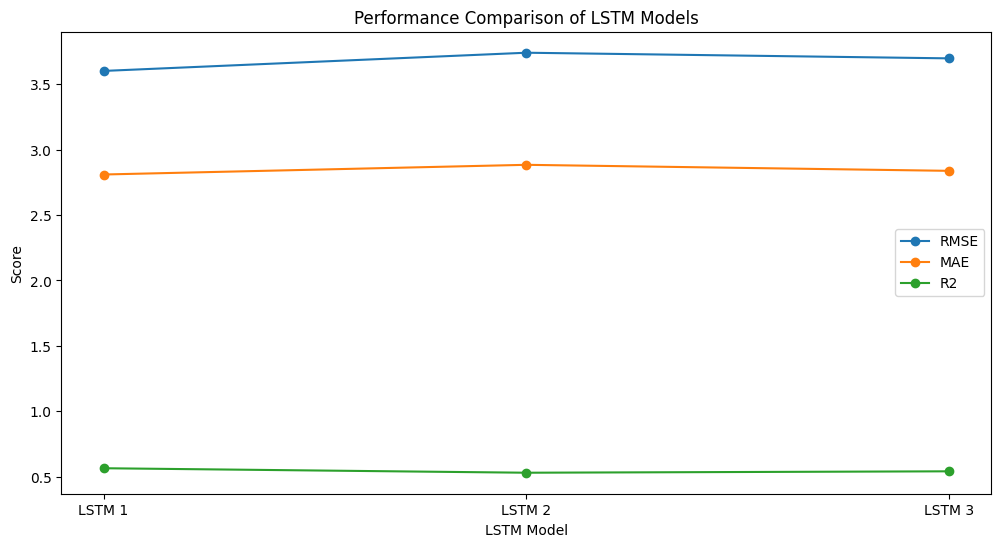

In [94]:
# Optional: Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.xlabel("LSTM Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

### ANN

In [96]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [97]:
# Load data
data = data_spring  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1706446326.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1706446326.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [98]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [ ]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape) 
print("Shape of y:", y.shape) 

Shape of X: (6561, 7, 1)
Shape of y: (6561,)


In [100]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [101]:
# Function to train and evaluate an ANN model
def train_evaluate_ann_model(hidden_units, epochs):
    model = Sequential()
    # Flatten input data to feed into Dense layers
    model.add(Dense(hidden_units[0], activation='relu', input_shape=(X_train.shape[1] * X_train.shape[2],)))
    
    # Add hidden layers based on the configuration
    for units in hidden_units[1:]:
        model.add(Dense(units, activation='relu'))
    
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=Adam(), loss='mse')
    
    # Flatten the input before feeding it to the model
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    # Train the model
    model.fit(X_train_flat, y_train, epochs=epochs, batch_size=16, validation_data=(X_val_flat, y_val), verbose=1)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test_flat)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    
    return rmse, mae, r2

In [102]:
# ANN configurations based on the table provided
ann_configs = [
    {'hidden_units': [2], 'epochs': 268},
    {'hidden_units': [4, 16], 'epochs': 263},
    {'hidden_units': [14, 8, 17], 'epochs': 100}
]

In [103]:
# Train and evaluate each configuration
results = []
for i, config in enumerate(ann_configs):
    rmse, mae, r2 = train_evaluate_ann_model(config['hidden_units'], config['epochs'])
    results.append({'Model': f'ANN {i+1}', 'Hidden Units': config['hidden_units'], 'Epochs': config['epochs'], 'RMSE': rmse, 'MAE': mae, 'R2': r2})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/268
263/263 [==============================] - 1s 3ms/step - loss: 0.6170 - val_loss: 0.0936
Epoch 2/268
263/263 [==============================] - 1s 3ms/step - loss: 0.0371 - val_loss: 0.0335
Epoch 3/268
263/263 [==============================] - 1s 3ms/step - loss: 0.0293 - val_loss: 0.0282
Epoch 4/268
263/263 [==============================] - 1s 3ms/step - loss: 0.0259 - val_loss: 0.0251
Epoch 5/268
263/263 [==============================] - 1s 3ms/step - loss: 0.0236 - val_loss: 0.0230
Epoch 6/268
263/263 [==============================] - 1s 3ms/step - loss: 0.0220 - val_loss: 0.0214
Epoch 7/268
263/263 [==============================] - 1s 4ms/step - loss: 0.0207 - val_loss: 0.0202
Epoch 8/268
263/263 [==============================] - 1s 3ms/step - loss: 0.0198 - val_loss: 0.0191
Epoch 9/268
263/263 [==============================] - 1s 3ms/step - loss: 0.0190 - val_loss: 0.0182
Epoch 10/268
263/263 [==============================] - 1s 3ms/step - loss: 0.0182 - val_lo

In [104]:
results_df

,Model,Hidden Units,Epochs,RMSE,MAE,R2
0,ANN 1,[2],268,3.640867,2.830830,0.555025
1,ANN 2,"[4, 16]",263,3.587098,2.808301,0.568071
2,ANN 3,"[14, 8, 17]",100,3.582611,2.820722,0.569151


In [105]:
results_df.to_csv(f'HASIL/ANN_SPRING.csv', index=False)

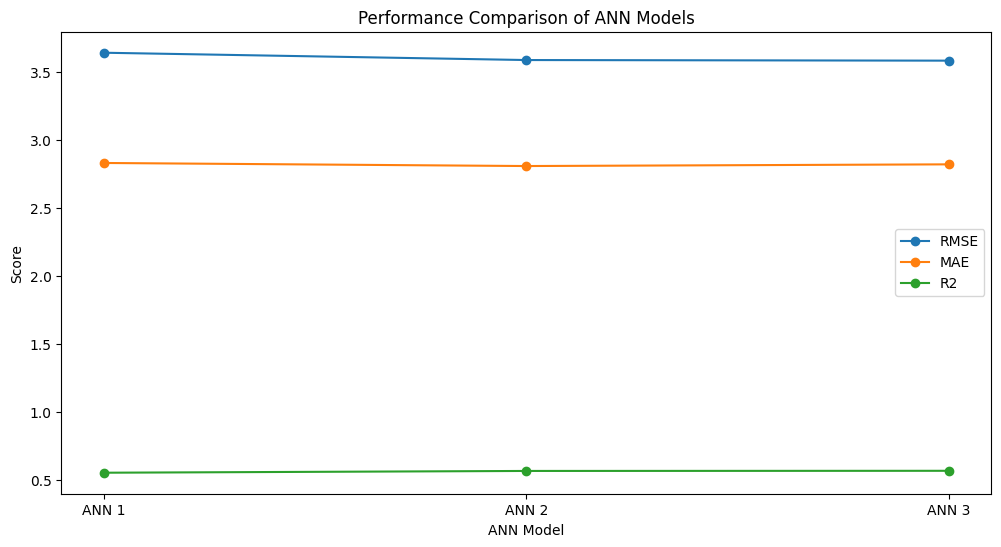

In [106]:
# Optional: Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.xlabel("ANN Model")
plt.ylabel("Score")
plt.title("Performance Comparison of ANN Models")
plt.legend()
plt.show()

## PREDIKSI 15 HARI

### RNN

In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
# Load data
data = data_spring  # Pastikan `data_winter` sudah dimuat sebagai DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1740994759.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1740994759.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [ ]:
def create_sequences(data, target, sequence_length=33, predict_days=15):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        # Create sequence with lag
        sequences.append(data[i:i + sequence_length].reshape(-1, 1)) 
        
        # Simulate prediction for the next 15 days (lag of 33)
        labels.append(np.nan)  

        # Simulate prediction: use the average of the last two values in the sequence
        last_two_values = data[i + sequence_length - 2:i + sequence_length]
        avg_last_two_values = np.mean(last_two_values)
        
        # Add the simulated prediction to labels (this will be used as the "prediction" for the future)
        labels[-1] = avg_last_two_values
    
    return np.array(sequences), np.array(labels)

In [ ]:
# Create sequences and target
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=33)

# Check shapes of X and y
print("Shape of X:", X.shape)  
print("Shape of y:", y.shape)  

Shape of X: (6386, 33, 1)
Shape of y: (6386,)


In [41]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [42]:
# Function to train and evaluate an RNN model
def train_evaluate_rnn_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            model.add(SimpleRNN(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            model.add(SimpleRNN(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))
    
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    
    return rmse, mae, r2, model

In [43]:
def predict_next_15_days(model, last_sequence, days=15):
    predictions = []
    current_input = last_sequence  # Start with the last available sequence
    
    for _ in range(days):
        # Predict the next day (model expects input in 3D: batch_size, sequence_length, features)
        pred = model.predict(current_input.reshape(1, current_input.shape[0], 1))  # Ensure it's 3D
        
        predictions.append(pred[0, 0])  # Append the scalar prediction value
        
        # Update the sequence by removing the first value and adding the predicted value at the end
        current_input = np.append(current_input[1:], pred)  # Add the predicted value to the sequence
        
        # Ensure the new sequence shape is correct for the next prediction
        current_input = current_input.reshape(-1, 1)  # Keep the sequence 2D for the next iteration
    
    # Rescale the predictions back to the original scale
    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_rescaled

In [44]:
# Define list containing different configurations for evaluation purposes
rnn_configs = [
    {'hidden_units': [5], 'epochs': 104},
    {'hidden_units': [1, 10], 'epochs': 156},
    {'hidden_units': [4, 4, 7], 'epochs': 204}
]

results = []

# Train and evaluate each configuration
for i, config in enumerate(rnn_configs):
    # Train and evaluate the model
    rmse, mae, r2, model = train_evaluate_rnn_model(config['hidden_units'], config['epochs'])
    
    # Append evaluation results to the list
    results.append({
        'Model': f'RNN {i+1}',
        'Hidden Units': config['hidden_units'],
        'Epochs': config['epochs'],
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Model_Object': model  # Save the model object for the best configuration
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("Evaluation Results:")
print(results_df)


Epoch 1/104
256/256 [==============================] - 3s 6ms/step - loss: 0.1269 - val_loss: 0.0617
Epoch 2/104
256/256 [==============================] - 1s 4ms/step - loss: 0.0356 - val_loss: 0.0191
Epoch 3/104
256/256 [==============================] - 1s 4ms/step - loss: 0.0146 - val_loss: 0.0119
Epoch 4/104
256/256 [==============================] - 1s 4ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 5/104
256/256 [==============================] - 1s 4ms/step - loss: 0.0113 - val_loss: 0.0107
Epoch 6/104
256/256 [==============================] - 1s 4ms/step - loss: 0.0106 - val_loss: 0.0099
Epoch 7/104
256/256 [==============================] - 1s 4ms/step - loss: 0.0094 - val_loss: 0.0083
Epoch 8/104
256/256 [==============================] - 1s 4ms/step - loss: 0.0070 - val_loss: 0.0040
Epoch 9/104
256/256 [==============================] - 1s 4ms/step - loss: 0.0012 - val_loss: 5.4906e-04
Epoch 10/104
256/256 [==============================] - 1s 4ms/step - loss: 5.2964e-04 

In [45]:
results_df

,Model,Hidden Units,Epochs,RMSE,MAE,R2,Model_Object
0,RNN 1,[5],104,0.004813,0.001438,0.999997,<keras.src.engine.sequential.Sequential object...
1,RNN 2,"[1, 10]",156,0.022368,0.021489,0.999940,<keras.src.engine.sequential.Sequential object...
2,RNN 3,"[4, 4, 7]",204,0.025740,0.017570,0.999921,<keras.src.engine.sequential.Sequential object...


In [46]:
results_df.to_csv(f'HASIL/15_RNN_SPRING.csv', index=False)

In [47]:
# Select the best model based on RMSE (lowest RMSE indicates best model)
best_model_index = results_df['RMSE'].idxmin()
best_model_info = results_df.iloc[best_model_index]
best_model = best_model_info['Model_Object']  # Retrieve the best model object

print("\nBest Model Configuration:")
print(best_model_info[['Model', 'Hidden Units', 'Epochs', 'RMSE', 'MAE', 'R2']])

# Use the best model to predict the next 15 days
last_sequence = X_test[-1]  # Use the last sequence from the test set
predictions_rescaled = predict_next_15_days(best_model, last_sequence)  # Get 15-day predictions

# Display the predictions
print("\nPredictions for the next 15 days using the best model:")
print(predictions_rescaled.flatten())


Best Model Configuration:
Model              RNN 1
Hidden Units         [5]
Epochs               104
RMSE            0.004813
MAE             0.001438
R2              0.999997
Name: 0, dtype: object
1/1 [==============================] - 0s 35ms/step

Predictions for the next 15 days using the best model:
[17.4994   17.45009  17.473074 17.460468 17.46583  17.462427 17.463552
 17.462584 17.462809 17.46255  17.462639 17.46266  17.462797 17.462942
 17.46315 ]


In [48]:
predictions_rescaled

array([[17.4994  ],
       [17.45009 ],
       [17.473074],
       [17.460468],
       [17.46583 ],
       [17.462427],
       [17.463552],
       [17.462584],
       [17.462809],
       [17.46255 ],
       [17.462639],
       [17.46266 ],
       [17.462797],
       [17.462942],
       [17.46315 ]], dtype=float32)

In [49]:
# Ubah menjadi DataFrame
df_predictions = pd.DataFrame(predictions_rescaled, columns=['Predicted_Value'])

In [50]:
df_predictions

,Predicted_Value
0,17.499399
1,17.450090
2,17.473074
3,17.460468
4,17.465830
5,17.462427
6,17.463552
7,17.462584
8,17.462809
9,17.462549


In [51]:
df_predictions.to_csv(f'HASIL_PREDICT/15_RNN_SPRING.csv', index=False)

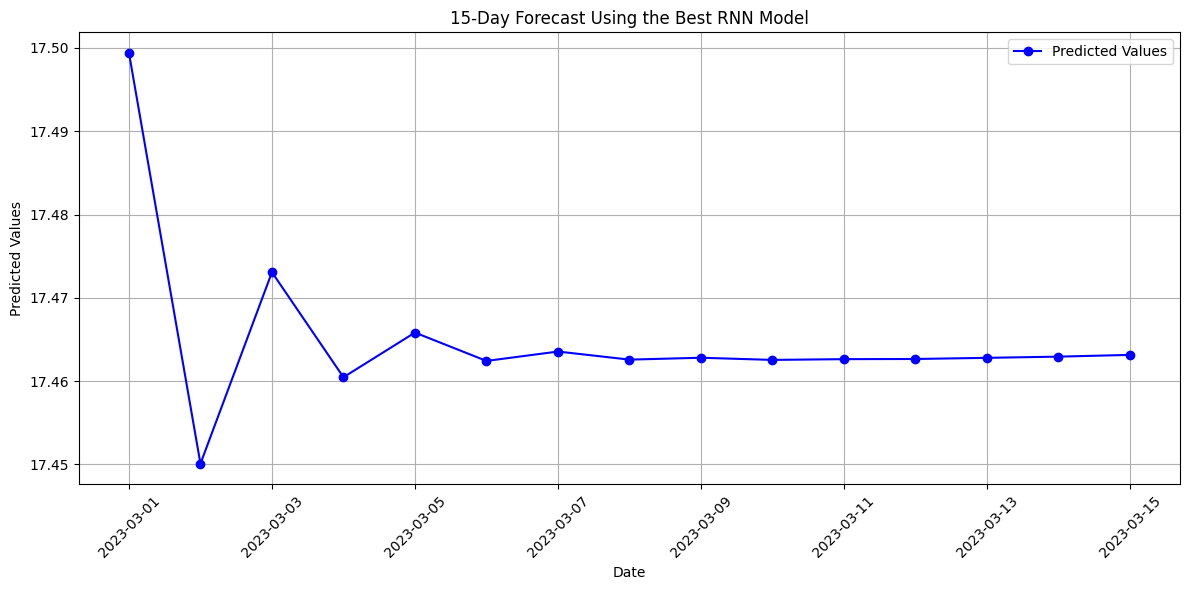

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Generate dates for the next 15 days for plotting purposes
from datetime import timedelta

last_date = pd.to_datetime(data_winter['date'].iloc[-1])  # Ambil tanggal terakhir dari data asli
future_dates = [last_date + timedelta(days=i) for i in range(1, 16)]

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions_rescaled.flatten(), marker='o', color='b', label='Predicted Values')
plt.title('15-Day Forecast Using the Best RNN Model')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

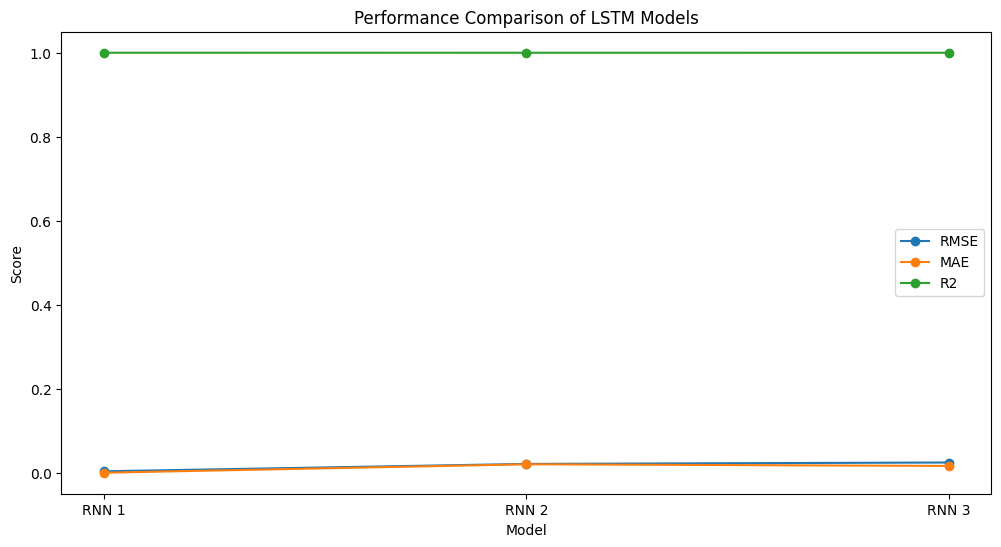

In [53]:
# Optional plotting of results
plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

### LSTM

In [108]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [109]:
# Load data
data = data_spring  # Pastikan `data_winter` sudah dimuat sebagai DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1486678579.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1486678579.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [110]:
def create_sequences(data, target, sequence_length=34, predict_days=15):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        # Create sequence with lag
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        
        # Simulate prediction for the next 15 days (lag of 34)
        labels.append(np.nan)  # Placeholder for actual label (for the time being, we'll calculate it)

        # Simulate prediction: use the average of the last two values in the sequence
        last_two_values = data[i + sequence_length - 2:i + sequence_length]  # Last two values of the sequence
        avg_last_two_values = np.mean(last_two_values)
        
        # Add the simulated prediction to labels (this will be used as the "prediction" for the future)
        labels[-1] = avg_last_two_values
    
    return np.array(sequences), np.array(labels)

In [111]:
# Create sequences and target
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=34)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6534, 34, 1)
Shape of y: (6534,)


In [112]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [113]:
def train_evaluate_lstm_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            # First LSTM layer with input shape
            model.add(LSTM(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            # Subsequent LSTM layers
            model.add(LSTM(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))
    
    # Output layer
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    
    # Return RMSE, MAE, R2, and model
    return rmse, mae, r2, model


In [114]:
def predict_next_15_days(model, last_sequence, days=15):
    predictions = []
    current_input = last_sequence  # Start with the last available sequence
    
    for _ in range(days):
        # Predict the next day (model expects input in 3D: batch_size, sequence_length, features)
        pred = model.predict(current_input.reshape(1, current_input.shape[0], 1))  # Ensure it's 3D
        
        predictions.append(pred[0, 0])  # Append the scalar prediction value
        
        # Update the sequence by removing the first value and adding the predicted value at the end
        current_input = np.append(current_input[1:], pred)  # Add the predicted value to the sequence
        
        # Ensure the new sequence shape is correct for the next prediction
        current_input = current_input.reshape(-1, 1)  # Keep the sequence 2D for the next iteration
    
    # Rescale the predictions back to the original scale
    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_rescaled

In [115]:
# Define list containing different configurations for evaluation purposes
lstm_configs = [
    {'hidden_units': [3], 'epochs': 273},
    {'hidden_units': [3, 20], 'epochs': 285},
    {'hidden_units': [6, 11, 18], 'epochs': 280}
]

results = []

# Train and evaluate each configuration
for i, config in enumerate(lstm_configs):
    # Train and evaluate the model
    rmse, mae, r2, model = train_evaluate_lstm_model(config['hidden_units'], config['epochs'])
    
    # Append evaluation results to the list
    results.append({
        'Model': f'LSTM {i+1}',
        'Hidden Units': config['hidden_units'],
        'Epochs': config['epochs'],
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Model_Object': model  # Save the model object for the best configuration
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("Evaluation Results:")
print(results_df)


Epoch 1/273
262/262 [==============================] - 5s 12ms/step - loss: 0.1875 - val_loss: 0.0325
Epoch 2/273
262/262 [==============================] - 3s 10ms/step - loss: 0.0253 - val_loss: 0.0216
Epoch 3/273
262/262 [==============================] - 3s 10ms/step - loss: 0.0171 - val_loss: 0.0149
Epoch 4/273
262/262 [==============================] - 2s 9ms/step - loss: 0.0118 - val_loss: 0.0106
Epoch 5/273
262/262 [==============================] - 2s 9ms/step - loss: 0.0087 - val_loss: 0.0080
Epoch 6/273
262/262 [==============================] - 2s 8ms/step - loss: 0.0068 - val_loss: 0.0065
Epoch 7/273
262/262 [==============================] - 2s 8ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 8/273
262/262 [==============================] - 2s 8ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 9/273
262/262 [==============================] - 2s 8ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 10/273
262/262 [==============================] - 2s 8ms/step - loss: 0.0031 - val

In [116]:
results_df

,Model,Hidden Units,Epochs,RMSE,MAE,R2,Model_Object
0,LSTM 1,[3],273,0.315612,0.240317,0.996095,<keras.src.engine.sequential.Sequential object...
1,LSTM 2,"[3, 20]",285,0.050533,0.048324,0.999900,<keras.src.engine.sequential.Sequential object...
2,LSTM 3,"[6, 11, 18]",280,0.052719,0.046798,0.999891,<keras.src.engine.sequential.Sequential object...


In [117]:
results_df.to_csv(f'HASIL/15_LSTM_SPRING.csv', index=False)

In [118]:
# Select the best model based on RMSE (lowest RMSE indicates best model)
best_model_index = results_df['RMSE'].idxmin()
best_model_info = results_df.iloc[best_model_index]
best_model = best_model_info['Model_Object']  # Retrieve the best model object

print("\nBest Model Configuration:")
print(best_model_info[['Model', 'Hidden Units', 'Epochs', 'RMSE', 'MAE', 'R2']])

# Use the best model to predict the next 15 days
last_sequence = X_test[-1]  # Use the last sequence from the test set
predictions_rescaled = predict_next_15_days(best_model, last_sequence)  # Get 15-day predictions

# Display the predictions
print("\nPredictions for the next 15 days using the best model:")
print(predictions_rescaled.flatten())


Best Model Configuration:
Model             LSTM 2
Hidden Units     [3, 20]
Epochs               285
RMSE            0.050533
MAE             0.048324
R2                0.9999
Name: 1, dtype: object
1/1 [==============================] - 0s 21ms/step

Predictions for the next 15 days using the best model:
[11.691795 11.481479 11.525018 11.43513  11.421686 11.365504 11.332563
 11.286868 11.247507 11.204364 11.162786 11.120056 11.077606 11.034947
 10.992435]


In [119]:
predictions_rescaled

array([[11.691795],
       [11.481479],
       [11.525018],
       [11.43513 ],
       [11.421686],
       [11.365504],
       [11.332563],
       [11.286868],
       [11.247507],
       [11.204364],
       [11.162786],
       [11.120056],
       [11.077606],
       [11.034947],
       [10.992435]], dtype=float32)

In [120]:
# Ubah menjadi DataFrame
df_predictions = pd.DataFrame(predictions_rescaled, columns=['Predicted_Value'])

In [121]:
df_predictions

,Predicted_Value
0,11.691795
1,11.481479
2,11.525018
3,11.435130
4,11.421686
5,11.365504
6,11.332563
7,11.286868
8,11.247507
9,11.204364


In [122]:
df_predictions.to_csv(f'HASIL_PREDICT/15_LSTM_SPRING.csv', index=False)

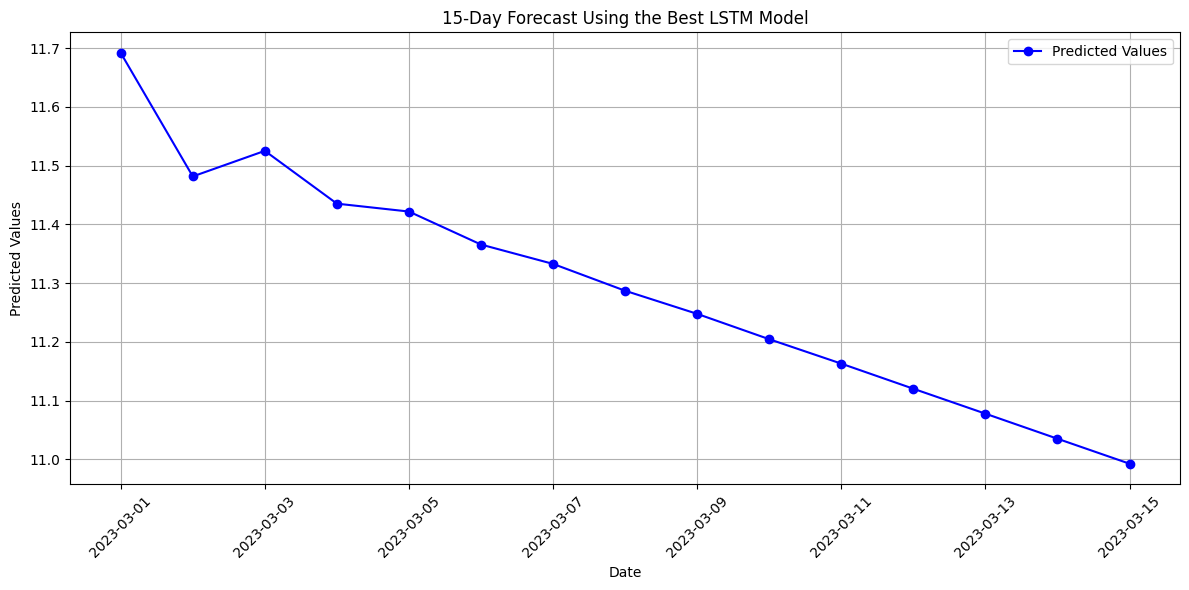

In [123]:
import matplotlib.pyplot as plt
import numpy as np

# Generate dates for the next 15 days for plotting purposes
from datetime import timedelta

last_date = pd.to_datetime(data_winter['date'].iloc[-1])  # Ambil tanggal terakhir dari data asli
future_dates = [last_date + timedelta(days=i) for i in range(1, 16)]

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions_rescaled.flatten(), marker='o', color='b', label='Predicted Values')
plt.title('15-Day Forecast Using the Best LSTM Model')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

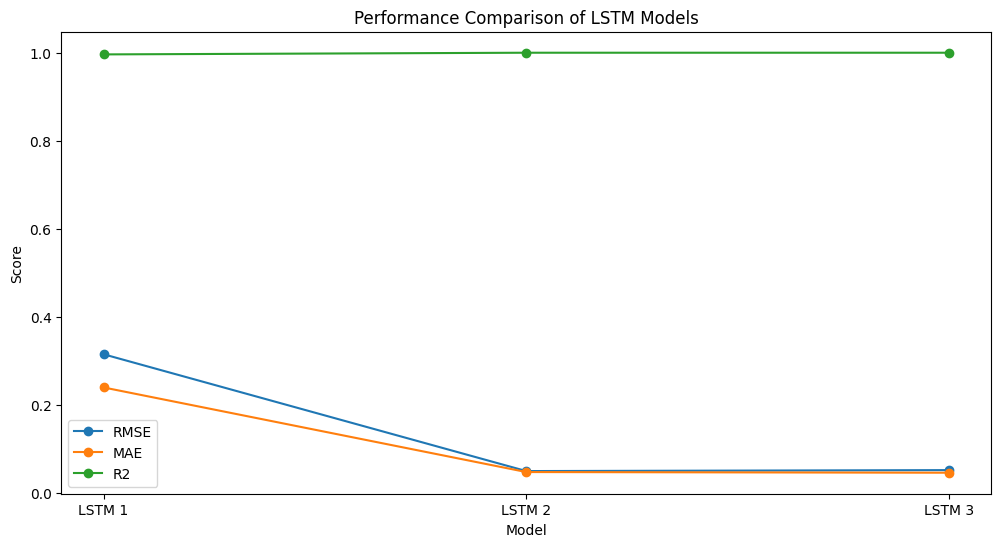

In [124]:
# Optional plotting of results
plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

### ANN

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [3]:
# Load data
data = data_spring  # Pastikan `data_winter` sudah dimuat sebagai DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_104372\1486678579.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_104372\1486678579.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [4]:
def create_sequences(data, target, sequence_length=33, predict_days=15):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        # Create sequence with lag
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        
        # Simulate prediction for the next 15 days (lag of 33)
        labels.append(np.nan)  # Placeholder for actual label (for the time being, we'll calculate it)

        # Simulate prediction: use the average of the last two values in the sequence
        last_two_values = data[i + sequence_length - 2:i + sequence_length]  # Last two values of the sequence
        avg_last_two_values = np.mean(last_two_values)
        
        # Add the simulated prediction to labels (this will be used as the "prediction" for the future)
        labels[-1] = avg_last_two_values
    
    return np.array(sequences), np.array(labels)

In [5]:
# Create sequences and target
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=33)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6535, 33, 1)
Shape of y: (6535,)


In [6]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [7]:
# Function to train and evaluate an ANN model
def train_evaluate_ann_model(hidden_units, epochs):
    model = Sequential()
    # Flatten input data to feed into Dense layers
    model.add(Dense(hidden_units[0], activation='relu', input_shape=(X_train.shape[1] * X_train.shape[2],)))
    
    # Add hidden layers based on the configuration
    for units in hidden_units[1:]:
        model.add(Dense(units, activation='relu'))
    
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=Adam(), loss='mse')
    
    # Flatten the input before feeding it to the model
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    # Train the model
    model.fit(X_train_flat, y_train, epochs=epochs, batch_size=16, validation_data=(X_val_flat, y_val), verbose=1)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test_flat)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    
    return rmse, mae, r2, model

In [8]:
last_sequence = X_test[-1].reshape(1, -1)

In [9]:
def predict_next_15_days(model, last_sequence, days=15):
    predictions = []
    current_input = last_sequence.flatten()  # Flatten the sequence to match the training input

    for _ in range(days):
        # Predict the next day using the flattened input
        pred = model.predict(current_input.reshape(1, -1))  # Ensure it's 2D as expected by the model
        
        predictions.append(pred[0, 0])  # Append the scalar prediction value
        
        # Update the sequence by removing the first value and adding the predicted value at the end
        current_input = np.append(current_input[1:], pred)  # Keep sequence 1D to match the model input
        
    # Rescale the predictions back to the original scale
    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_rescaled


In [10]:
# Define list containing different configurations for evaluation purposes
ann_configs = [
    {'hidden_units': [2], 'epochs': 268},
    {'hidden_units': [4, 16], 'epochs': 263},
    {'hidden_units': [14, 8, 17], 'epochs': 100}
]

results = []

# Train and evaluate each configuration
for i, config in enumerate(ann_configs):
    # Train and evaluate the model
    rmse, mae, r2, model = train_evaluate_ann_model(config['hidden_units'], config['epochs'])
    
    # Append evaluation results to the list
    results.append({
        'Model': f'ANN {i+1}',
        'Hidden Units': config['hidden_units'],
        'Epochs': config['epochs'],
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Model_Object': model  # Save the model object for the best configuration
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("Evaluation Results:")
print(results_df)



Epoch 1/268

262/262 [==============================] - 1s 2ms/step - loss: 0.0511 - val_loss: 0.0331
Epoch 2/268
262/262 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0247
Epoch 3/268
262/262 [==============================] - 1s 2ms/step - loss: 0.0219 - val_loss: 0.0192
Epoch 4/268
262/262 [==============================] - 1s 2ms/step - loss: 0.0170 - val_loss: 0.0148
Epoch 5/268
262/262 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0114
Epoch 6/268
262/262 [==============================] - 0s 2ms/step - loss: 0.0098 - val_loss: 0.0083
Epoch 7/268
262/262 [==============================] - 0s 1ms/step - loss: 0.0072 - val_loss: 0.0060
Epoch 8/268
262/262 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0043
Epoch 9/268
262/262 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0031
Epoch 10/268
262/262 [==============================] - 0s 2ms/step - loss: 0.0028 - val_

In [11]:
results_df

,Model,Hidden Units,Epochs,RMSE,MAE,R2,Model_Object
0,ANN 1,[2],268,0.000364,0.000336,1.000000,<keras.src.engine.sequential.Sequential object...
1,ANN 2,"[4, 16]",263,0.027014,0.026207,0.999972,<keras.src.engine.sequential.Sequential object...
2,ANN 3,"[14, 8, 17]",100,0.069149,0.054011,0.999815,<keras.src.engine.sequential.Sequential object...


In [14]:
results_df.to_csv(f'HASIL/15_ANN_SPRING.csv', index=False)

In [12]:
# Select the best model based on RMSE (lowest RMSE indicates best model)
best_model_index = results_df['RMSE'].idxmin()
best_model_info = results_df.iloc[best_model_index]
best_model = best_model_info['Model_Object']  # Retrieve the best model object

print("\nBest Model Configuration:")
print(best_model_info[['Model', 'Hidden Units', 'Epochs', 'RMSE', 'MAE', 'R2']])

# Use the best model to predict the next 15 days
last_sequence = X_test[-1]  # Use the last sequence from the test set
predictions_rescaled = predict_next_15_days(best_model, last_sequence)  # Get 15-day predictions

# Display the predictions
print("\nPredictions for the next 15 days using the best model:")
print(predictions_rescaled.flatten())


Best Model Configuration:
Model              ANN 1
Hidden Units         [2]
Epochs               268
RMSE            0.000364
MAE             0.000336
R2                   1.0
Name: 0, dtype: object
1/1 [==============================] - 0s 22ms/step

Predictions for the next 15 days using the best model:
[10.199414 11.149396 10.673887 10.911309 10.792287 10.851505 10.821572
 10.836157 10.828484 10.831874 10.829734 10.830471 10.829897 10.829833
 10.829775]


In [13]:
predictions_rescaled

array([[10.199414],
       [11.149396],
       [10.673887],
       [10.911309],
       [10.792287],
       [10.851505],
       [10.821572],
       [10.836157],
       [10.828484],
       [10.831874],
       [10.829734],
       [10.830471],
       [10.829897],
       [10.829833],
       [10.829775]], dtype=float32)

In [15]:
# Ubah menjadi DataFrame
df_predictions = pd.DataFrame(predictions_rescaled, columns=['Predicted_Value'])

In [16]:
df_predictions

,Predicted_Value
0,10.199414
1,11.149396
2,10.673887
3,10.911309
4,10.792287
5,10.851505
6,10.821572
7,10.836157
8,10.828484
9,10.831874


In [17]:
df_predictions.to_csv(f'HASIL_PREDICT/15_ANN_SPRING.csv', index=False)

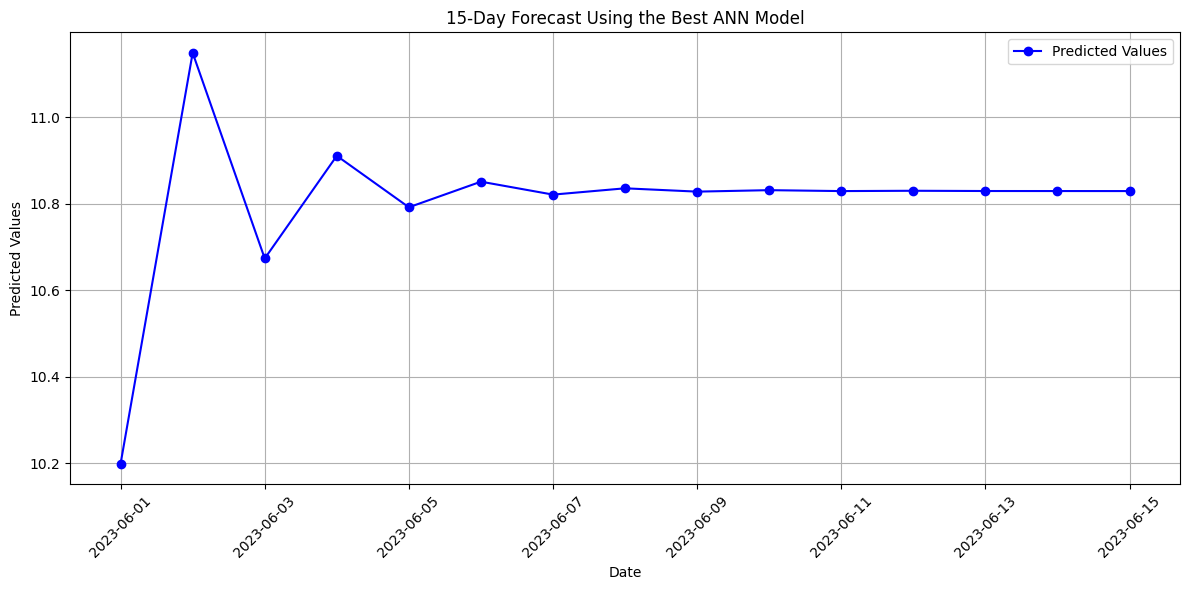

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Generate dates for the next 15 days for plotting purposes
from datetime import timedelta

last_date = pd.to_datetime(data_spring['date'].iloc[-1])  # Ambil tanggal terakhir dari data asli
future_dates = [last_date + timedelta(days=i) for i in range(1, 16)]

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions_rescaled.flatten(), marker='o', color='b', label='Predicted Values')
plt.title('15-Day Forecast Using the Best ANN Model')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

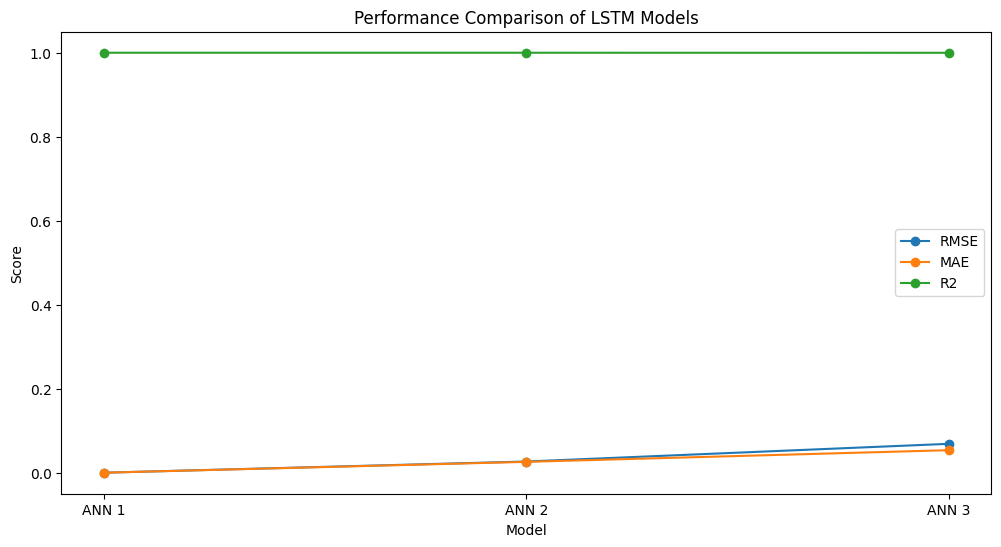

In [20]:
# Optional plotting of results
plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

# SUMMER

In [2]:
import pandas as pd
data_summer = pd.read_csv('DATASET/SEASON/data_Summer.csv')
data_summer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6588 entries, 0 to 6587
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  6588 non-null   int64  
 1   city_name   6588 non-null   object 
 2   date        6588 non-null   object 
 3   season      6588 non-null   object 
 4   avg_temp_c  6394 non-null   float64
 5   min_temp_c  6365 non-null   float64
 6   max_temp_c  6588 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 360.4+ KB


In [3]:
data_summer

,station_id,city_name,date,season,avg_temp_c,min_temp_c,max_temp_c
0,47662,Tokyo,1951-06-01,Summer,NaN,18.1,25.4
1,47662,Tokyo,1951-06-02,Summer,NaN,16.2,30.0
2,47662,Tokyo,1951-06-03,Summer,NaN,17.4,30.3
3,47662,Tokyo,1951-06-04,Summer,NaN,17.7,26.5
4,47662,Tokyo,1951-06-05,Summer,NaN,18.8,25.2
...,...,...,...,...,...,...,...
6583,47662,Tokyo,2023-08-27,Summer,27.3,24.8,30.2
6584,47662,Tokyo,2023-08-28,Summer,28.2,25.0,31.5
6585,47662,Tokyo,2023-08-29,Summer,29.5,26.7,33.3
6586,47662,Tokyo,2023-08-30,Summer,29.5,26.9,32.8


## PREDIKSI 1 HARI

### RNN

In [145]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [146]:
# Load data
data = data_summer  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1071411982.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1071411982.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [147]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [148]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6581, 7, 1)
Shape of y: (6581,)


In [149]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [150]:
# Function to train and evaluate an RNN model
def train_evaluate_rnn_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            model.add(SimpleRNN(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            model.add(SimpleRNN(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))
    
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    
    return rmse, mae, r2

In [151]:
# RNN configurations based on the table provided
rnn_configs = [
    {'hidden_units': [8], 'epochs': 50},
    {'hidden_units': [6, 13], 'epochs': 156},
    {'hidden_units': [1, 10, 12], 'epochs': 156}
]

# Train and evaluate each configuration
results = []
for i, config in enumerate(rnn_configs):
    rmse, mae, r2 = train_evaluate_rnn_model(config['hidden_units'], config['epochs'])
    results.append({'Model': f'RNN {i+1}', 'Hidden Units': config['hidden_units'], 'Epochs': config['epochs'], 'RMSE': rmse, 'MAE': mae, 'R2': r2})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/50
264/264 [==============================] - 1s 2ms/step - loss: 0.0122 - val_loss: 0.0106
Epoch 2/50
264/264 [==============================] - 0s 2ms/step - loss: 0.0111 - val_loss: 0.0103
Epoch 3/50
264/264 [==============================] - 0s 2ms/step - loss: 0.0109 - val_loss: 0.0103
Epoch 4/50
264/264 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0103
Epoch 5/50
264/264 [==============================] - 0s 2ms/step - loss: 0.0109 - val_loss: 0.0104
Epoch 6/50
264/264 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0103
Epoch 7/50
264/264 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0102
Epoch 8/50
264/264 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0103
Epoch 9/50
264/264 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0102
Epoch 10/50
264/264 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0103

In [152]:
results_df

,Model,Hidden Units,Epochs,RMSE,MAE,R2
0,RNN 1,[8],50,2.709360,2.047913,0.556473
1,RNN 2,"[6, 13]",156,2.702813,2.032675,0.558615
2,RNN 3,"[1, 10, 12]",156,2.736316,2.047577,0.547604


In [153]:
results_df.to_csv(f'HASIL/RNN_SUMMER.csv', index=False)

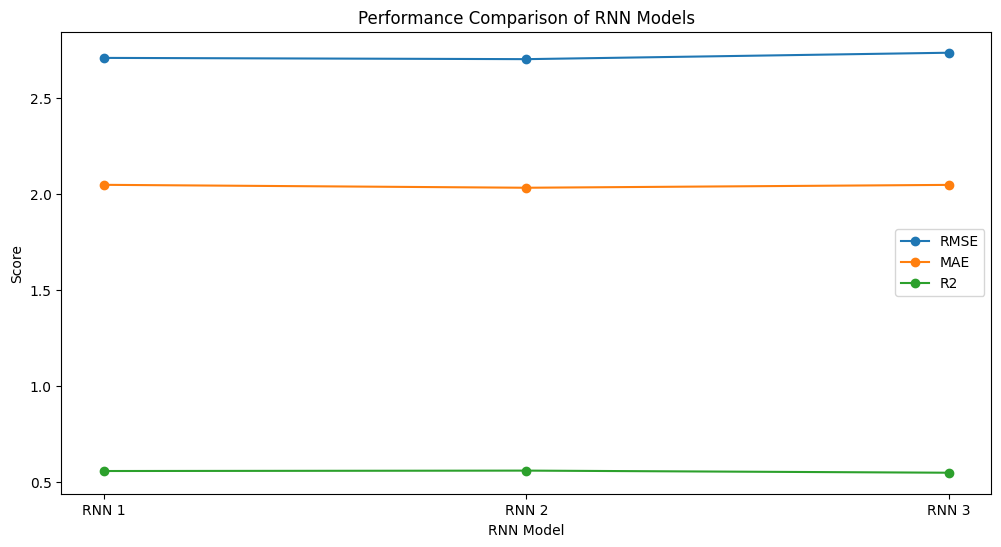

In [154]:
# Optional: Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.xlabel("RNN Model")
plt.ylabel("Score")
plt.title("Performance Comparison of RNN Models")
plt.legend()
plt.show()

### LSTM

In [155]:
from tensorflow.keras.layers import LSTM

In [156]:
# Load data
data = data_summer  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1071411982.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1071411982.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [157]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [158]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6581, 7, 1)
Shape of y: (6581,)


In [159]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [160]:
def train_evaluate_lstm_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            # First LSTM layer with input shape
            model.add(LSTM(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            # Subsequent LSTM layers
            model.add(LSTM(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))
    
    # Output layer
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    
    return rmse, mae, r2

In [161]:
# LSTM configurations based on the table provided
lstm_configs = [
    {'hidden_units': [3], 'epochs': 25},
    {'hidden_units': [6,6], 'epochs': 91},
    {'hidden_units': [1, 19, 17], 'epochs': 156}
]

# Train and evaluate each configuration
results = []
for i, config in enumerate(lstm_configs):
    rmse, mae, r2 = train_evaluate_rnn_model(config['hidden_units'], config['epochs'])
    results.append({'Model': f'LSTM {i+1}', 'Hidden Units': config['hidden_units'], 'Epochs': config['epochs'], 'RMSE': rmse, 'MAE': mae, 'R2': r2})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/25
264/264 [==============================] - 2s 3ms/step - loss: 0.1030 - val_loss: 0.0144
Epoch 2/25
264/264 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0138
Epoch 3/25
264/264 [==============================] - 1s 2ms/step - loss: 0.0138 - val_loss: 0.0131
Epoch 4/25
264/264 [==============================] - 1s 2ms/step - loss: 0.0131 - val_loss: 0.0125
Epoch 5/25
264/264 [==============================] - 1s 2ms/step - loss: 0.0125 - val_loss: 0.0120
Epoch 6/25
264/264 [==============================] - 1s 2ms/step - loss: 0.0121 - val_loss: 0.0118
Epoch 7/25
264/264 [==============================] - 1s 2ms/step - loss: 0.0119 - val_loss: 0.0115
Epoch 8/25
264/264 [==============================] - 1s 2ms/step - loss: 0.0115 - val_loss: 0.0111
Epoch 9/25
264/264 [==============================] - 1s 2ms/step - loss: 0.0114 - val_loss: 0.0110
Epoch 10/25
264/264 [==============================] - 1s 2ms/step - loss: 0.0113 - val_loss: 0.0109

In [162]:
results_df

,Model,Hidden Units,Epochs,RMSE,MAE,R2
0,LSTM 1,[3],25,0.102524,0.077965,0.550632
1,LSTM 2,"[6, 6]",91,0.102691,0.079047,0.549166
2,LSTM 3,"[1, 19, 17]",156,0.152970,0.127903,-0.000367


In [163]:
results_df.to_csv(f'HASIL/LSTM_SUMMER.csv', index=False)

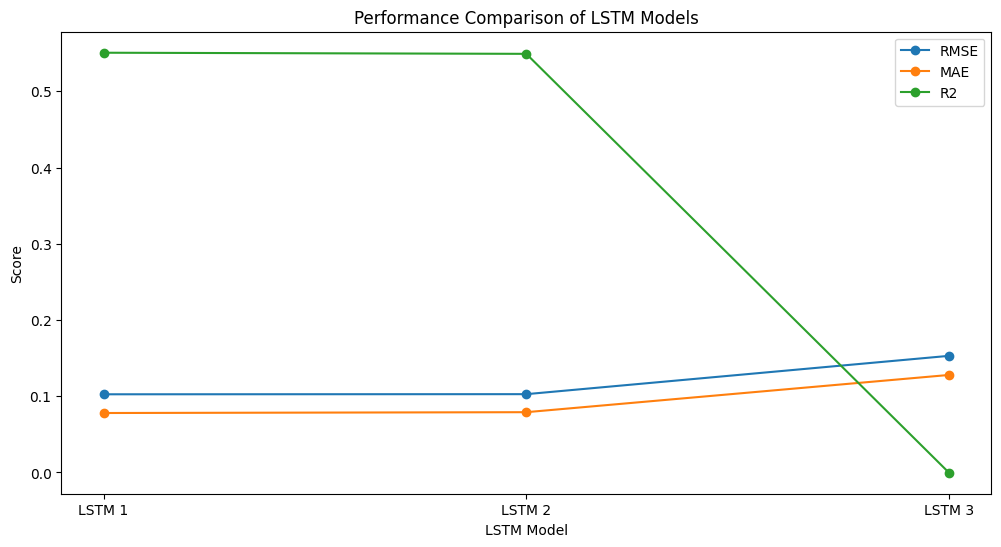

In [164]:
# Optional: Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.xlabel("LSTM Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

### ANN

In [165]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [166]:
# Load data
data = data_summer  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True) 

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_100324\71918029.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_100324\71918029.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [167]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [168]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6581, 7, 1)
Shape of y: (6581,)


In [169]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [170]:
# Function to train and evaluate an ANN model
def train_evaluate_ann_model(hidden_units, epochs):
    model = Sequential()
    # Flatten input data to feed into Dense layers
    model.add(Dense(hidden_units[0], activation='relu', input_shape=(X_train.shape[1] * X_train.shape[2],)))
    
    # Add hidden layers based on the configuration
    for units in hidden_units[1:]:
        model.add(Dense(units, activation='relu'))
    
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=Adam(), loss='mse')
    
    # Flatten the input before feeding it to the model
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    # Train the model
    model.fit(X_train_flat, y_train, epochs=epochs, batch_size=16, validation_data=(X_val_flat, y_val), verbose=1)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test_flat)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    
    return rmse, mae, r2

In [171]:
# ANN configurations based on the table provided
ann_configs = [
    {'hidden_units': [2], 'epochs': 268},
    {'hidden_units': [6, 5], 'epochs': 263},
    {'hidden_units': [11, 11, 2], 'epochs': 288}
]

In [172]:
# Train and evaluate each configuration
results = []
for i, config in enumerate(ann_configs):
    rmse, mae, r2 = train_evaluate_ann_model(config['hidden_units'], config['epochs'])
    results.append({'Model': f'ANN {i+1}', 'Hidden Units': config['hidden_units'], 'Epochs': config['epochs'], 'RMSE': rmse, 'MAE': mae, 'R2': r2})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/268
264/264 [==============================] - 1s 2ms/step - loss: 0.1430 - val_loss: 0.0228
Epoch 2/268
264/264 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0209
Epoch 3/268
264/264 [==============================] - 0s 2ms/step - loss: 0.0198 - val_loss: 0.0194
Epoch 4/268
264/264 [==============================] - 0s 1ms/step - loss: 0.0184 - val_loss: 0.0180
Epoch 5/268
264/264 [==============================] - 0s 1ms/step - loss: 0.0172 - val_loss: 0.0168
Epoch 6/268
264/264 [==============================] - 0s 1ms/step - loss: 0.0162 - val_loss: 0.0159
Epoch 7/268
264/264 [==============================] - 0s 1ms/step - loss: 0.0154 - val_loss: 0.0153
Epoch 8/268
264/264 [==============================] - 0s 2ms/step - loss: 0.0147 - val_loss: 0.0144
Epoch 9/268
264/264 [==============================] - 0s 1ms/step - loss: 0.0141 - val_loss: 0.0139
Epoch 10/268
264/264 [==============================] - 0s 1ms/step - loss: 0.0135 - val_lo

In [173]:
results_df

,Model,Hidden Units,Epochs,RMSE,MAE,R2
0,ANN 1,[2],268,0.102645,0.079420,0.549575
1,ANN 2,"[6, 5]",263,0.103066,0.080193,0.545865
2,ANN 3,"[11, 11, 2]",288,0.102469,0.077016,0.551118


In [174]:
results_df.to_csv(f'HASIL/ANN_SUMMER.csv', index=False)

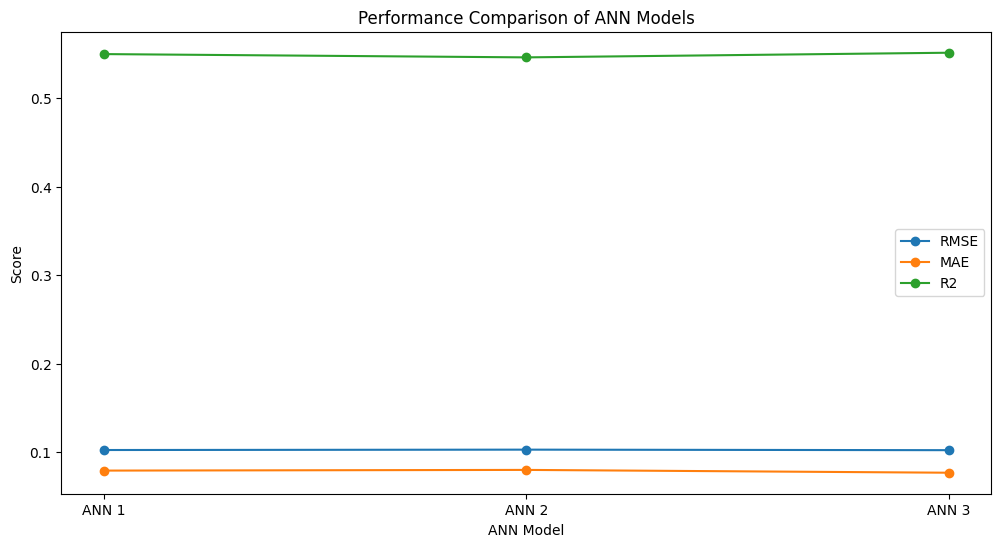

In [175]:
# Optional: Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.xlabel("ANN Model")
plt.ylabel("Score")
plt.title("Performance Comparison of ANN Models")
plt.legend()
plt.show()

## PREDIKSI 15 HARI

### RNN

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [24]:
# Load data
data = data_summer  # Pastikan `data_winter` sudah dimuat sebagai DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_99100\1297502850.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_99100\1297502850.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [25]:
data

,station_id,city_name,date,season,avg_temp_c,min_temp_c,max_temp_c
0,47662,Tokyo,1951-06-01,Summer,NaN,18.1,0.469925
1,47662,Tokyo,1951-06-02,Summer,NaN,16.2,0.642857
2,47662,Tokyo,1951-06-03,Summer,NaN,17.4,0.654135
3,47662,Tokyo,1951-06-04,Summer,NaN,17.7,0.511278
4,47662,Tokyo,1951-06-05,Summer,NaN,18.8,0.462406
...,...,...,...,...,...,...,...
6583,47662,Tokyo,2023-08-27,Summer,27.3,24.8,0.650376
6584,47662,Tokyo,2023-08-28,Summer,28.2,25.0,0.699248
6585,47662,Tokyo,2023-08-29,Summer,29.5,26.7,0.766917
6586,47662,Tokyo,2023-08-30,Summer,29.5,26.9,0.748120


In [26]:
def create_sequences(data, target, sequence_length=12, predict_days=15):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        # Create sequence with lag
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        
        # Simulate prediction for the next 15 days (lag of 12)
        labels.append(np.nan)  # Placeholder for actual label (for the time being, we'll calculate it)

        # Simulate prediction: use the average of the last two values in the sequence
        last_two_values = data[i + sequence_length - 2:i + sequence_length]  # Last two values of the sequence
        avg_last_two_values = np.mean(last_two_values)
        
        # Add the simulated prediction to labels (this will be used as the "prediction" for the future)
        labels[-1] = avg_last_two_values
    
    return np.array(sequences), np.array(labels)

In [27]:
# Create sequences and target
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=12)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6576, 12, 1)
Shape of y: (6576,)


In [28]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [29]:
# Function to train and evaluate an RNN model
def train_evaluate_rnn_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            model.add(SimpleRNN(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            model.add(SimpleRNN(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))
    
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    
    return rmse, mae, r2, model

In [30]:
# Fungsi prediksi untuk 15 hari ke depan
def predict_next_15_days(model, last_sequence, days=15):
    predictions = []
    current_input = last_sequence  # Mulai dengan sequence terakhir
    
    for _ in range(days):
        pred = model.predict(current_input.reshape(1, current_input.shape[0], 1))
        predictions.append(pred[0, 0])
        current_input = np.append(current_input[1:], pred).reshape(-1, 1)
    
    # Ubah prediksi ke skala aslinya
    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_rescaled

In [31]:
# Define list containing different configurations for evaluation purposes
rnn_configs = [
    {'hidden_units': [8], 'epochs': 50},
    {'hidden_units': [6, 13], 'epochs': 156},
    {'hidden_units': [1, 10, 12], 'epochs': 156}
]

results = []

# Train and evaluate each configuration
for i, config in enumerate(rnn_configs):
    # Train and evaluate the model
    rmse, mae, r2, model = train_evaluate_rnn_model(config['hidden_units'], config['epochs'])
    
    # Append evaluation results to the list
    results.append({
        'Model': f'RNN {i+1}',
        'Hidden Units': config['hidden_units'],
        'Epochs': config['epochs'],
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Model_Object': model  # Save the model object for the best configuration
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("Evaluation Results:")
print(results_df)


Epoch 1/50
263/263 [==============================] - 2s 4ms/step - loss: 0.1686 - val_loss: 0.0016
Epoch 2/50
263/263 [==============================] - 1s 3ms/step - loss: 6.4558e-04 - val_loss: 2.4719e-04
Epoch 3/50
263/263 [==============================] - 1s 4ms/step - loss: 1.5729e-04 - val_loss: 6.5371e-05
Epoch 4/50
263/263 [==============================] - 1s 3ms/step - loss: 4.9040e-05 - val_loss: 3.3355e-05
Epoch 5/50
263/263 [==============================] - 1s 3ms/step - loss: 3.0013e-05 - val_loss: 1.9979e-05
Epoch 6/50
263/263 [==============================] - 1s 3ms/step - loss: 1.6485e-05 - val_loss: 2.1020e-05
Epoch 7/50
263/263 [==============================] - 1s 3ms/step - loss: 1.0044e-05 - val_loss: 6.4500e-06
Epoch 8/50
263/263 [==============================] - 1s 4ms/step - loss: 5.9840e-06 - val_loss: 6.4633e-06
Epoch 9/50
263/263 [==============================] - 1s 3ms/step - loss: 4.7526e-06 - val_loss: 3.8888e-06
Epoch 10/50
263/263 [===============

In [32]:
results_df

,Model,Hidden Units,Epochs,RMSE,MAE,R2,Model_Object
0,RNN 1,[8],50,0.020192,0.018019,0.999973,<keras.src.engine.sequential.Sequential object...
1,RNN 2,"[6, 13]",156,0.011567,0.005365,0.999991,<keras.src.engine.sequential.Sequential object...
2,RNN 3,"[1, 10, 12]",156,3.860981,3.274889,-0.000887,<keras.src.engine.sequential.Sequential object...


In [37]:
results_df.to_csv(f'HASIL/15_RNN_SUMMER.csv', index=False)

In [33]:
# Select the best model based on RMSE (lowest RMSE indicates best model)
best_model_index = results_df['RMSE'].idxmin()
best_model_info = results_df.iloc[best_model_index]
best_model = best_model_info['Model_Object']  # Retrieve the best model object

print("\nBest Model Configuration:")
print(best_model_info[['Model', 'Hidden Units', 'Epochs', 'RMSE', 'MAE', 'R2']])

# Use the best model to predict the next 15 days
last_sequence = X_test[-1]  # Use the last sequence from the test set
predictions_rescaled = predict_next_15_days(best_model, last_sequence)  # Get 15-day predictions

# Display the predictions
print("\nPredictions for the next 15 days using the best model:")
print(predictions_rescaled.flatten())


Best Model Configuration:
Model              RNN 2
Hidden Units     [6, 13]
Epochs               156
RMSE            0.011567
MAE             0.005365
R2              0.999991
Name: 1, dtype: object
1/1 [==============================] - 0s 23ms/step

Predictions for the next 15 days using the best model:
[26.753399 27.577435 27.168793 27.371386 27.26936  27.319641 27.293766
 27.306221 27.304161 27.304445 27.30869  27.308111 27.31136  27.31199
 27.314283]


In [34]:
predictions_rescaled

array([[26.753399],
       [27.577435],
       [27.168793],
       [27.371386],
       [27.26936 ],
       [27.319641],
       [27.293766],
       [27.306221],
       [27.304161],
       [27.304445],
       [27.30869 ],
       [27.308111],
       [27.31136 ],
       [27.31199 ],
       [27.314283]], dtype=float32)

In [35]:
# Ubah menjadi DataFrame
df_predictions = pd.DataFrame(predictions_rescaled, columns=['Predicted_Value'])

In [36]:
df_predictions

,Predicted_Value
0,26.753399
1,27.577435
2,27.168793
3,27.371386
4,27.269360
5,27.319641
6,27.293766
7,27.306221
8,27.304161
9,27.304445


In [38]:
df_predictions.to_csv(f'HASIL_PREDICT/15_RNN_SUMMER.csv', index=False)

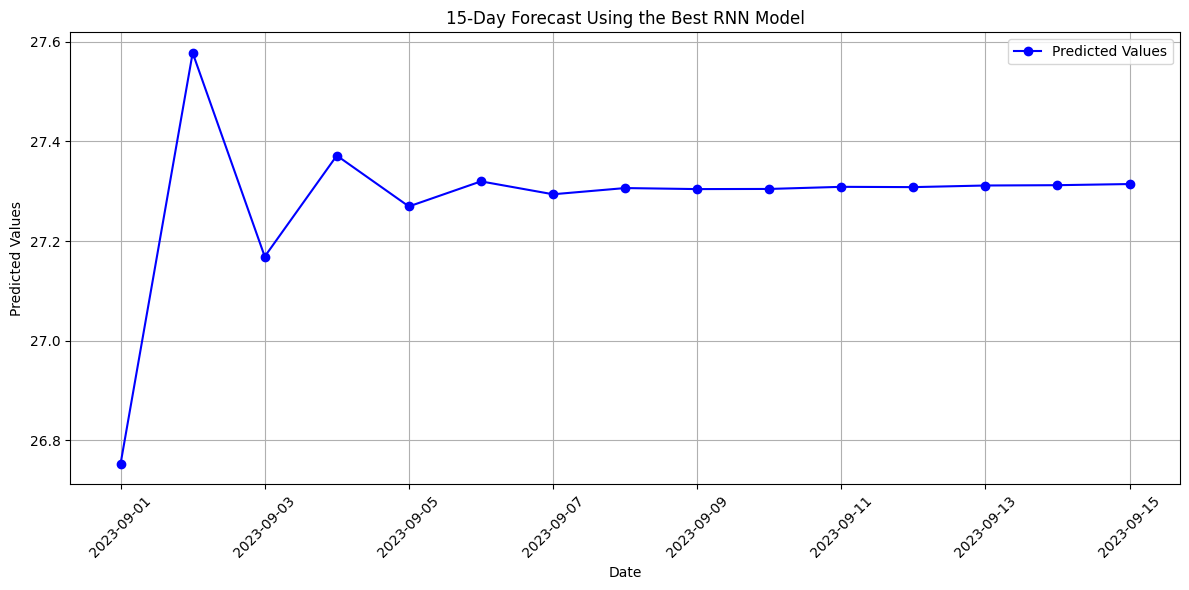

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Generate dates for the next 15 days for plotting purposes
from datetime import timedelta

last_date = pd.to_datetime(data_summer['date'].iloc[-1])  # Ambil tanggal terakhir dari data asli
future_dates = [last_date + timedelta(days=i) for i in range(1, 16)]

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions_rescaled.flatten(), marker='o', color='b', label='Predicted Values')
plt.title('15-Day Forecast Using the Best RNN Model')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

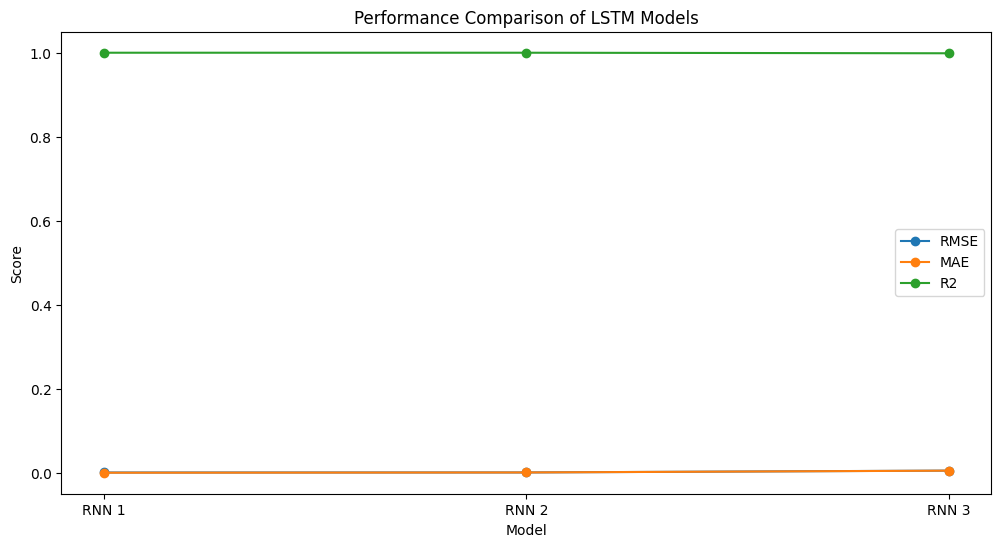

In [192]:
# Optional plotting of results
plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

### LSTM

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [4]:
# Load data
data = data_summer  # Pastikan `data_winter` sudah dimuat sebagai DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_100768\1297502850.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_100768\1297502850.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [5]:
def create_sequences(data, target, sequence_length=35, predict_days=15):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        # Create sequence with lag
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        
        # Simulate prediction for the next 15 days (lag of 35)
        labels.append(np.nan)  # Placeholder for actual label (for the time being, we'll calculate it)

        # Simulate prediction: use the average of the last two values in the sequence
        last_two_values = data[i + sequence_length - 2:i + sequence_length]  # Last two values of the sequence
        avg_last_two_values = np.mean(last_two_values)
        
        # Add the simulated prediction to labels (this will be used as the "prediction" for the future)
        labels[-1] = avg_last_two_values
    
    return np.array(sequences), np.array(labels)

In [6]:
# Create sequences and target
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=35)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6553, 35, 1)
Shape of y: (6553,)


In [7]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [8]:
def train_evaluate_lstm_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            # First LSTM layer with input shape
            model.add(LSTM(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            # Subsequent LSTM layers
            model.add(LSTM(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))
    
    # Output layer
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    
    # Return RMSE, MAE, R2, and model
    return rmse, mae, r2, model


In [9]:
# Fungsi prediksi untuk 15 hari ke depan
def predict_next_15_days(model, last_sequence, days=15):
    predictions = []
    current_input = last_sequence  # Mulai dengan sequence terakhir
    
    for _ in range(days):
        pred = model.predict(current_input.reshape(1, current_input.shape[0], 1))
        predictions.append(pred[0, 0])
        current_input = np.append(current_input[1:], pred).reshape(-1, 1)
    
    # Ubah prediksi ke skala aslinya
    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_rescaled

In [10]:
# Define list containing different configurations for evaluation purposes
lstm_configs = [
    {'hidden_units': [3], 'epochs': 25},
    {'hidden_units': [6,6], 'epochs': 91},
    {'hidden_units': [1, 19, 17], 'epochs': 156}
]

results = []

# Train and evaluate each configuration
for i, config in enumerate(lstm_configs):
    # Train and evaluate the model
    rmse, mae, r2, model = train_evaluate_lstm_model(config['hidden_units'], config['epochs'])
    
    # Append evaluation results to the list
    results.append({
        'Model': f'LSTM {i+1}',
        'Hidden Units': config['hidden_units'],
        'Epochs': config['epochs'],
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Model_Object': model  # Save the model object for the best configuration
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("Evaluation Results:")
print(results_df)



Epoch 1/25

263/263 [==============================] - 4s 8ms/step - loss: 0.2815 - val_loss: 0.1555
Epoch 2/25
263/263 [==============================] - 2s 7ms/step - loss: 0.1020 - val_loss: 0.0588
Epoch 3/25
263/263 [==============================] - 2s 9ms/step - loss: 0.0391 - val_loss: 0.0240
Epoch 4/25
263/263 [==============================] - 2s 8ms/step - loss: 0.0176 - val_loss: 0.0087
Epoch 5/25
263/263 [==============================] - 3s 11ms/step - loss: 0.0029 - val_loss: 0.0010
Epoch 6/25
263/263 [==============================] - 3s 11ms/step - loss: 7.0748e-04 - val_loss: 5.5115e-04
Epoch 7/25
263/263 [==============================] - 3s 10ms/step - loss: 5.0226e-04 - val_loss: 4.3702e-04
Epoch 8/25
263/263 [==============================] - 2s 9ms/step - loss: 4.1966e-04 - val_loss: 3.4840e-04
Epoch 9/25
263/263 [==============================] - 3s 10ms/step - loss: 3.6778e-04 - val_loss: 2.9252e-04
Epoch 10/25
263/263 [==============================] - 2s 9ms/

In [11]:
results_df

,Model,Hidden Units,Epochs,RMSE,MAE,R2,Model_Object
0,LSTM 1,[3],25,0.269784,0.210935,0.995085,<keras.src.engine.sequential.Sequential object...
1,LSTM 2,"[6, 6]",91,0.248080,0.242053,0.995844,<keras.src.engine.sequential.Sequential object...
2,LSTM 3,"[1, 19, 17]",156,3.849767,3.246808,-0.000878,<keras.src.engine.sequential.Sequential object...


In [202]:
results_df.to_csv(f'HASIL/15_LSTM_SUMMER.csv', index=False)

In [13]:
# Select the best model based on RMSE (lowest RMSE indicates best model)
best_model_index = results_df['RMSE'].idxmin()
best_model_info = results_df.iloc[best_model_index]
best_model = best_model_info['Model_Object']  # Retrieve the best model object

print("\nBest Model Configuration:")
print(best_model_info[['Model', 'Hidden Units', 'Epochs', 'RMSE', 'MAE', 'R2']])

# Use the best model to predict the next 15 days
last_sequence = X_test[-1]  # Use the last sequence from the test set
predictions_rescaled = predict_next_15_days(best_model, last_sequence)  # Get 15-day predictions

# Display the predictions
print("\nPredictions for the next 15 days using the best model:")
print(predictions_rescaled.flatten())


Best Model Configuration:
Model             LSTM 2
Hidden Units      [6, 6]
Epochs                91
RMSE             0.24808
MAE             0.242053
R2              0.995844
Name: 1, dtype: object
1/1 [==============================] - 0s 32ms/step

Predictions for the next 15 days using the best model:
[27.335924 27.199478 27.03319  26.86105  26.710178 26.550583 26.395227
 26.236996 26.079048 25.920687 25.763237 25.605476 25.448233 25.292212
 25.13706 ]


In [14]:
predictions_rescaled

array([[27.335924],
       [27.199478],
       [27.03319 ],
       [26.86105 ],
       [26.710178],
       [26.550583],
       [26.395227],
       [26.236996],
       [26.079048],
       [25.920687],
       [25.763237],
       [25.605476],
       [25.448233],
       [25.292212],
       [25.13706 ]], dtype=float32)

In [15]:
# Ubah menjadi DataFrame
df_predictions = pd.DataFrame(predictions_rescaled, columns=['Predicted_Value'])

In [16]:
df_predictions

,Predicted_Value
0,27.335924
1,27.199478
2,27.033190
3,26.861050
4,26.710178
5,26.550583
6,26.395227
7,26.236996
8,26.079048
9,25.920687


In [17]:
df_predictions.to_csv(f'HASIL_PREDICT/15_LSTM_SUMMER.csv', index=False)

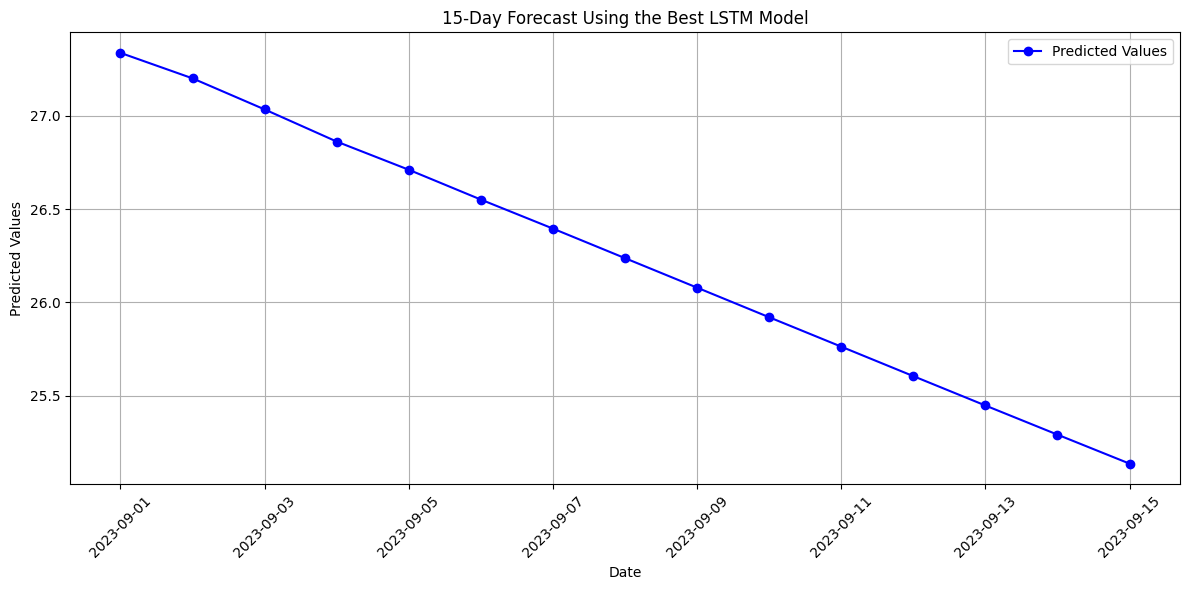

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Generate dates for the next 15 days for plotting purposes
from datetime import timedelta

last_date = pd.to_datetime(data_summer['date'].iloc[-1])  # Ambil tanggal terakhir dari data asli
future_dates = [last_date + timedelta(days=i) for i in range(1, 16)]

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions_rescaled.flatten(), marker='o', color='b', label='Predicted Values')
plt.title('15-Day Forecast Using the Best LSTM Model')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

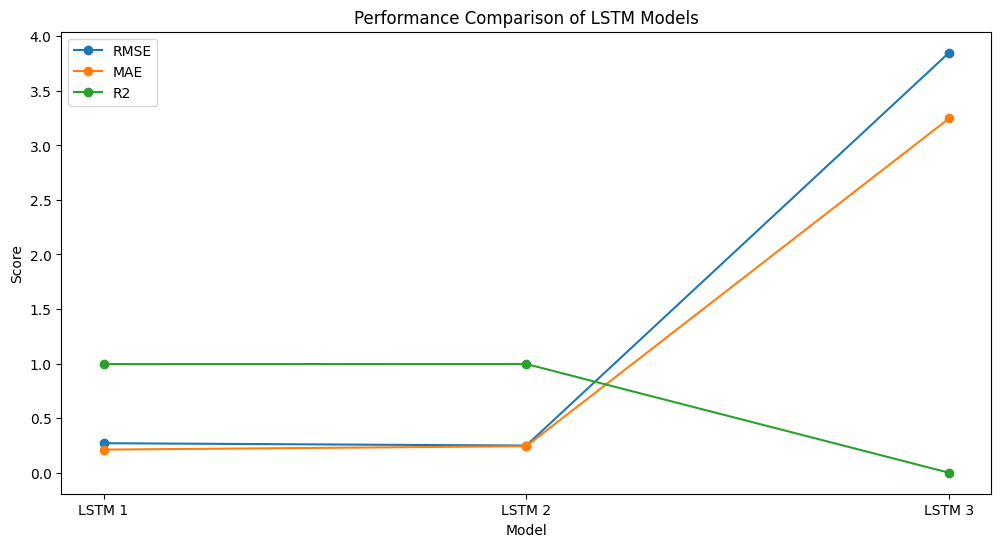

In [19]:
# Optional plotting of results
plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

### ANN

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [5]:
# Load data
data = data_summer  # Pastikan `data_winter` sudah dimuat sebagai DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_81168\1297502850.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_81168\1297502850.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [6]:
def create_sequences(data, target, sequence_length=15, predict_days=15):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        # Create sequence with lag
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        
        # Simulate prediction for the next 15 days (lag of 15)
        labels.append(np.nan)  # Placeholder for actual label (for the time being, we'll calculate it)

        # Simulate prediction: use the average of the last two values in the sequence
        last_two_values = data[i + sequence_length - 2:i + sequence_length]  # Last two values of the sequence
        avg_last_two_values = np.mean(last_two_values)
        
        # Add the simulated prediction to labels (this will be used as the "prediction" for the future)
        labels[-1] = avg_last_two_values
    
    return np.array(sequences), np.array(labels)

In [7]:
# Create sequences and target
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=15)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6573, 15, 1)
Shape of y: (6573,)


In [8]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [9]:
# Function to train and evaluate an ANN model
def train_evaluate_ann_model(hidden_units, epochs):
    model = Sequential()
    # Flatten input data to feed into Dense layers
    model.add(Dense(hidden_units[0], activation='relu', input_shape=(X_train.shape[1] * X_train.shape[2],)))
    
    # Add hidden layers based on the configuration
    for units in hidden_units[1:]:
        model.add(Dense(units, activation='relu'))
    
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=Adam(), loss='mse')
    
    # Flatten the input before feeding it to the model
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    # Train the model
    model.fit(X_train_flat, y_train, epochs=epochs, batch_size=16, validation_data=(X_val_flat, y_val), verbose=1)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test_flat)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    
    return rmse, mae, r2, model

In [10]:
last_sequence = X_test[-1].reshape(1, -1)

In [15]:
def predict_next_15_days(model, last_sequence, days=15):
    predictions = []
    current_input = last_sequence.flatten()  # Flatten the sequence to match the training input

    for _ in range(days):
        # Predict the next day using the flattened input
        pred = model.predict(current_input.reshape(1, -1))  # Ensure it's 2D as expected by the model
        
        predictions.append(pred[0, 0])  # Append the scalar prediction value
        
        # Update the sequence by removing the first value and adding the predicted value at the end
        current_input = np.append(current_input[1:], pred)  # Keep sequence 1D to match the model input
        
    # Rescale the predictions back to the original scale
    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_rescaled


In [12]:
# Define list containing different configurations for evaluation purposes
ann_configs = [
    {'hidden_units': [2], 'epochs': 268},
    {'hidden_units': [6, 5], 'epochs': 263},
    {'hidden_units': [11, 11, 2], 'epochs': 288}
]

results = []

# Train and evaluate each configuration
for i, config in enumerate(ann_configs):
    # Train and evaluate the model
    rmse, mae, r2, model = train_evaluate_ann_model(config['hidden_units'], config['epochs'])
    
    # Append evaluation results to the list
    results.append({
        'Model': f'ANN {i+1}',
        'Hidden Units': config['hidden_units'],
        'Epochs': config['epochs'],
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Model_Object': model  # Save the model object for the best configuration
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("Evaluation Results:")
print(results_df)



Epoch 1/268

263/263 [==============================] - 1s 2ms/step - loss: 0.2532 - val_loss: 0.1601
Epoch 2/268
263/263 [==============================] - 0s 2ms/step - loss: 0.0964 - val_loss: 0.0623
Epoch 3/268
263/263 [==============================] - 1s 2ms/step - loss: 0.0391 - val_loss: 0.0306
Epoch 4/268
263/263 [==============================] - 1s 2ms/step - loss: 0.0235 - val_loss: 0.0229
Epoch 5/268
263/263 [==============================] - 1s 2ms/step - loss: 0.0195 - val_loss: 0.0193
Epoch 6/268
263/263 [==============================] - 0s 2ms/step - loss: 0.0178 - val_loss: 0.0179
Epoch 7/268
263/263 [==============================] - 0s 2ms/step - loss: 0.0165 - val_loss: 0.0165
Epoch 8/268
263/263 [==============================] - 1s 2ms/step - loss: 0.0152 - val_loss: 0.0149
Epoch 9/268
263/263 [==============================] - 0s 2ms/step - loss: 0.0136 - val_loss: 0.0133
Epoch 10/268
263/263 [==============================] - 1s 2ms/step - loss: 0.0117 - val_

In [13]:
results_df

,Model,Hidden Units,Epochs,RMSE,MAE,R2,Model_Object
0,ANN 1,[2],268,0.026735,0.004830,0.999952,<keras.src.engine.sequential.Sequential object...
1,ANN 2,"[6, 5]",263,0.039319,0.021580,0.999897,<keras.src.engine.sequential.Sequential object...
2,ANN 3,"[11, 11, 2]",288,0.026037,0.014112,0.999955,<keras.src.engine.sequential.Sequential object...


In [18]:
results_df.to_csv(f'HASIL/15_ANN_SUMMER.csv', index=False)

In [16]:
# Select the best model based on RMSE (lowest RMSE indicates best model)
best_model_index = results_df['RMSE'].idxmin()
best_model_info = results_df.iloc[best_model_index]
best_model = best_model_info['Model_Object']  # Retrieve the best model object

print("\nBest Model Configuration:")
print(best_model_info[['Model', 'Hidden Units', 'Epochs', 'RMSE', 'MAE', 'R2']])

# Use the best model to predict the next 15 days
last_sequence = X_test[-1]  # Use the last sequence from the test set
predictions_rescaled = predict_next_15_days(best_model, last_sequence)  # Get 15-day predictions

# Display the predictions
print("\nPredictions for the next 15 days using the best model:")
print(predictions_rescaled.flatten())


Best Model Configuration:
Model                 ANN 3
Hidden Units    [11, 11, 2]
Epochs                  288
RMSE               0.026037
MAE                0.014112
R2                 0.999955
Name: 2, dtype: object
1/1 [==============================] - 0s 26ms/step

Predictions for the next 15 days using the best model:
[28.639471 28.65701  28.636475 28.633104 28.624552 28.6164   28.609718
 28.599758 28.592592 28.583475 28.575773 28.566547 28.558064 28.549171
 28.540508]


In [17]:
predictions_rescaled

array([[28.639471],
       [28.65701 ],
       [28.636475],
       [28.633104],
       [28.624552],
       [28.6164  ],
       [28.609718],
       [28.599758],
       [28.592592],
       [28.583475],
       [28.575773],
       [28.566547],
       [28.558064],
       [28.549171],
       [28.540508]], dtype=float32)

In [19]:
# Ubah menjadi DataFrame
df_predictions = pd.DataFrame(predictions_rescaled, columns=['Predicted_Value'])

In [20]:
df_predictions

,Predicted_Value
0,28.639471
1,28.657009
2,28.636475
3,28.633104
4,28.624552
5,28.616400
6,28.609718
7,28.599758
8,28.592592
9,28.583475


In [21]:
df_predictions.to_csv(f'HASIL_PREDICT/15_ANN_SUMMER.csv', index=False)

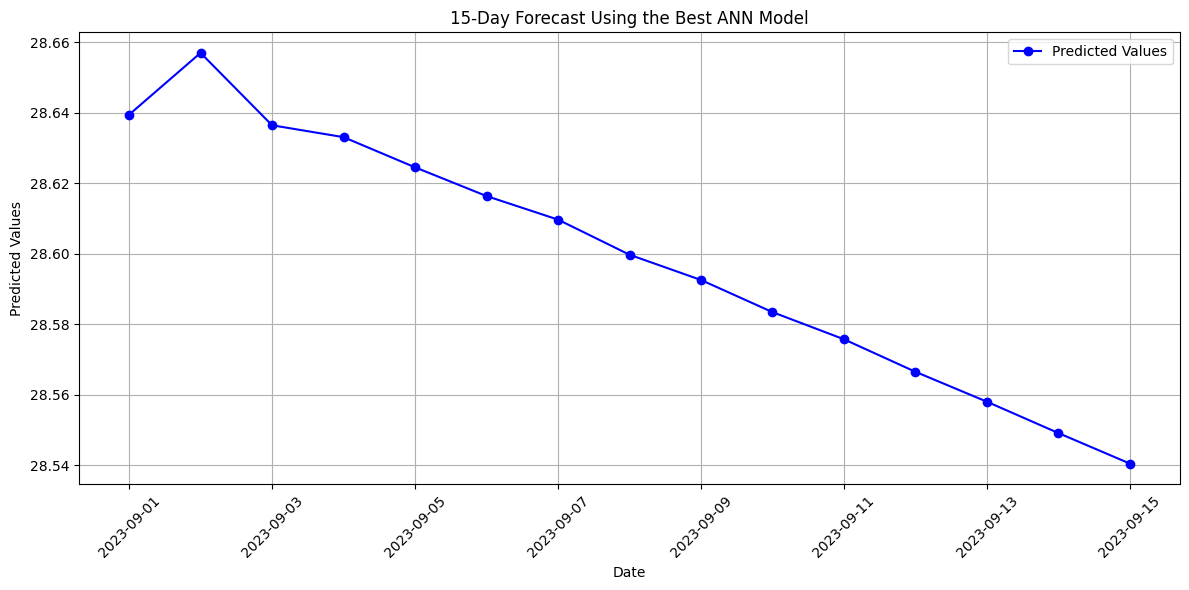

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Generate dates for the next 15 days for plotting purposes
from datetime import timedelta

last_date = pd.to_datetime(data_summer['date'].iloc[-1])  # Ambil tanggal terakhir dari data asli
future_dates = [last_date + timedelta(days=i) for i in range(1, 16)]

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions_rescaled.flatten(), marker='o', color='b', label='Predicted Values')
plt.title('15-Day Forecast Using the Best ANN Model')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

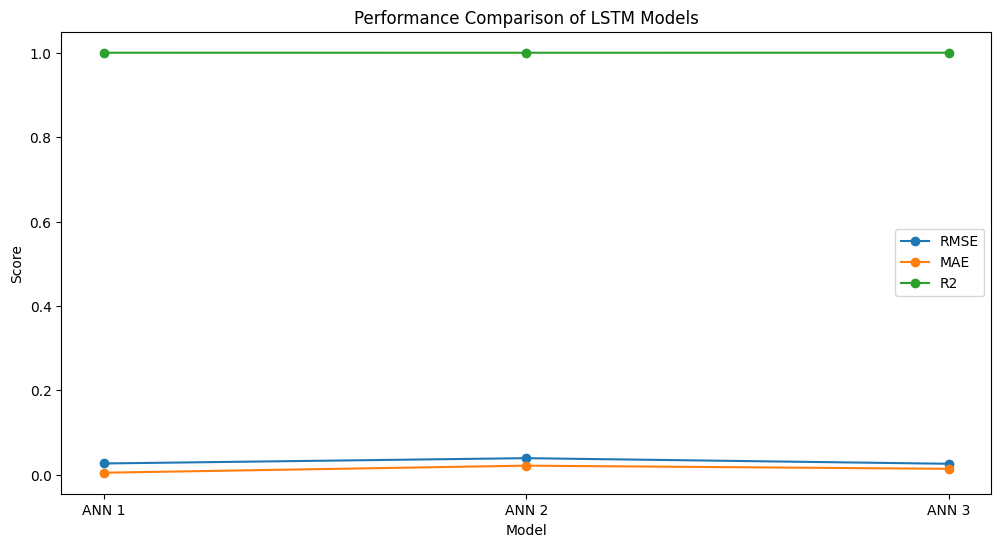

In [23]:
# Optional plotting of results
plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

# AUTUMN

In [1]:
import pandas as pd
data_autumn = pd.read_csv('DATASET/SEASON/data_Autumn.csv')
data_autumn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6416 entries, 0 to 6415
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  6416 non-null   int64  
 1   city_name   6416 non-null   object 
 2   date        6416 non-null   object 
 3   season      6416 non-null   object 
 4   avg_temp_c  6228 non-null   float64
 5   min_temp_c  6181 non-null   float64
 6   max_temp_c  6416 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 351.0+ KB


In [3]:
data_autumn

,station_id,city_name,date,season,avg_temp_c,min_temp_c,max_temp_c
0,47662,Tokyo,1951-09-01,Autumn,NaN,22.5,30.4
1,47662,Tokyo,1951-09-02,Autumn,NaN,21.5,29.8
2,47662,Tokyo,1951-09-03,Autumn,NaN,18.6,30.3
3,47662,Tokyo,1951-09-04,Autumn,NaN,19.5,27.4
4,47662,Tokyo,1951-09-05,Autumn,NaN,20.5,24.7
...,...,...,...,...,...,...,...
6411,47662,Tokyo,2023-09-01,Autumn,28.9,26.2,32.1
6412,47662,Tokyo,2023-09-02,Autumn,28.3,26.0,31.3
6413,47662,Tokyo,2023-09-03,Autumn,26.8,25.0,29.2
6414,47662,Tokyo,2023-09-04,Autumn,26.1,24.0,28.7


## PREDIKSI 1 HARI

### RNN

In [230]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [231]:
# Load data
data = data_autumn  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1450894011.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1450894011.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [232]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [233]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6409, 7, 1)
Shape of y: (6409,)


In [234]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [235]:
# Function to train and evaluate an RNN model
def train_evaluate_rnn_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            model.add(SimpleRNN(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            model.add(SimpleRNN(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))
    
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    
    return rmse, mae, r2

In [236]:
# RNN configurations based on the table provided
rnn_configs = [
    {'hidden_units': [3], 'epochs': 292},
    {'hidden_units': [17, 9], 'epochs': 123},
    {'hidden_units': [4, 4, 17], 'epochs': 92}
]

# Train and evaluate each configuration
results = []
for i, config in enumerate(rnn_configs):
    rmse, mae, r2 = train_evaluate_rnn_model(config['hidden_units'], config['epochs'])
    results.append({'Model': f'RNN {i+1}', 'Hidden Units': config['hidden_units'], 'Epochs': config['epochs'], 'RMSE': rmse, 'MAE': mae, 'R2': r2})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/292
257/257 [==============================] - 2s 3ms/step - loss: 0.0277 - val_loss: 0.0153
Epoch 2/292
257/257 [==============================] - 1s 2ms/step - loss: 0.0141 - val_loss: 0.0141
Epoch 3/292
257/257 [==============================] - 1s 2ms/step - loss: 0.0133 - val_loss: 0.0135
Epoch 4/292
257/257 [==============================] - 1s 2ms/step - loss: 0.0129 - val_loss: 0.0131
Epoch 5/292
257/257 [==============================] - 1s 2ms/step - loss: 0.0126 - val_loss: 0.0126
Epoch 6/292
257/257 [==============================] - 1s 2ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 7/292
257/257 [==============================] - 1s 2ms/step - loss: 0.0124 - val_loss: 0.0122
Epoch 8/292
257/257 [==============================] - 1s 2ms/step - loss: 0.0122 - val_loss: 0.0121
Epoch 9/292
257/257 [==============================] - 1s 2ms/step - loss: 0.0122 - val_loss: 0.0120
Epoch 10/292
257/257 [==============================] - 1s 2ms/step - loss: 0.0121 - val_lo

In [237]:
results_df

,Model,Hidden Units,Epochs,RMSE,MAE,R2
0,RNN 1,[3],292,3.315120,2.583591,0.624021
1,RNN 2,"[17, 9]",123,3.401514,2.646886,0.604169
2,RNN 3,"[4, 4, 17]",92,5.424738,4.473649,-0.006753


In [238]:
results_df.to_csv(f'HASIL/RNN_AUTUMN.csv', index=False)

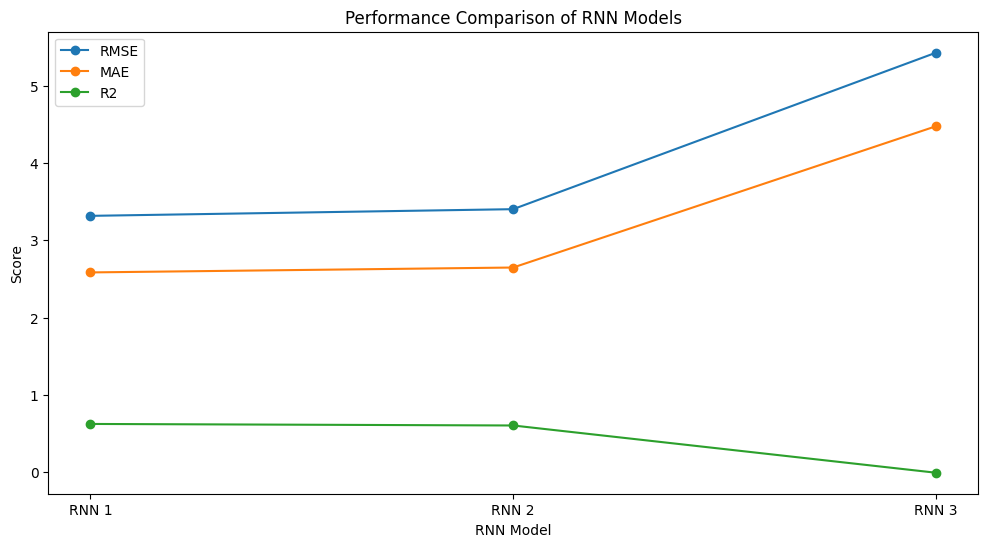

In [239]:
# Optional: Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.xlabel("RNN Model")
plt.ylabel("Score")
plt.title("Performance Comparison of RNN Models")
plt.legend()
plt.show()

### LSTM

In [240]:
from tensorflow.keras.layers import LSTM

In [241]:
# Load data
data = data_autumn  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1450894011.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1450894011.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [242]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [243]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6409, 7, 1)
Shape of y: (6409,)


In [244]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [245]:
def train_evaluate_lstm_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            # First LSTM layer with input shape
            model.add(LSTM(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            # Subsequent LSTM layers
            model.add(LSTM(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))
    
    # Output layer
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    
    return rmse, mae, r2

In [246]:
# LSTM configurations based on the table provided
lstm_configs = [
    {'hidden_units': [14], 'epochs': 105},
    {'hidden_units': [15, 2], 'epochs': 229},
    {'hidden_units': [12, 7, 4], 'epochs': 111}
]

# Train and evaluate each configuration
results = []
for i, config in enumerate(lstm_configs):
    rmse, mae, r2 = train_evaluate_rnn_model(config['hidden_units'], config['epochs'])
    results.append({'Model': f'LSTM {i+1}', 'Hidden Units': config['hidden_units'], 'Epochs': config['epochs'], 'RMSE': rmse, 'MAE': mae, 'R2': r2})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/105
257/257 [==============================] - 2s 3ms/step - loss: 0.0230 - val_loss: 0.0135
Epoch 2/105
257/257 [==============================] - 1s 2ms/step - loss: 0.0130 - val_loss: 0.0117
Epoch 3/105
257/257 [==============================] - 1s 2ms/step - loss: 0.0120 - val_loss: 0.0111
Epoch 4/105
257/257 [==============================] - 1s 2ms/step - loss: 0.0116 - val_loss: 0.0124
Epoch 5/105
257/257 [==============================] - 1s 2ms/step - loss: 0.0116 - val_loss: 0.0116
Epoch 6/105
257/257 [==============================] - 1s 2ms/step - loss: 0.0114 - val_loss: 0.0115
Epoch 7/105
257/257 [==============================] - 1s 2ms/step - loss: 0.0113 - val_loss: 0.0114
Epoch 8/105
257/257 [==============================] - 1s 2ms/step - loss: 0.0112 - val_loss: 0.0110
Epoch 9/105
257/257 [==============================] - 1s 2ms/step - loss: 0.0113 - val_loss: 0.0108
Epoch 10/105
257/257 [==============================] - 1s 2ms/step - loss: 0.0112 - val_lo

In [247]:
results_df

,Model,Hidden Units,Epochs,RMSE,MAE,R2
0,LSTM 1,[14],105,0.102679,0.080306,0.623698
1,LSTM 2,"[15, 2]",229,0.167504,0.138043,-0.001434
2,LSTM 3,"[12, 7, 4]",111,0.103180,0.080619,0.620018


In [248]:
results_df.to_csv(f'HASIL/LSTM_AUTUMN.csv', index=False)

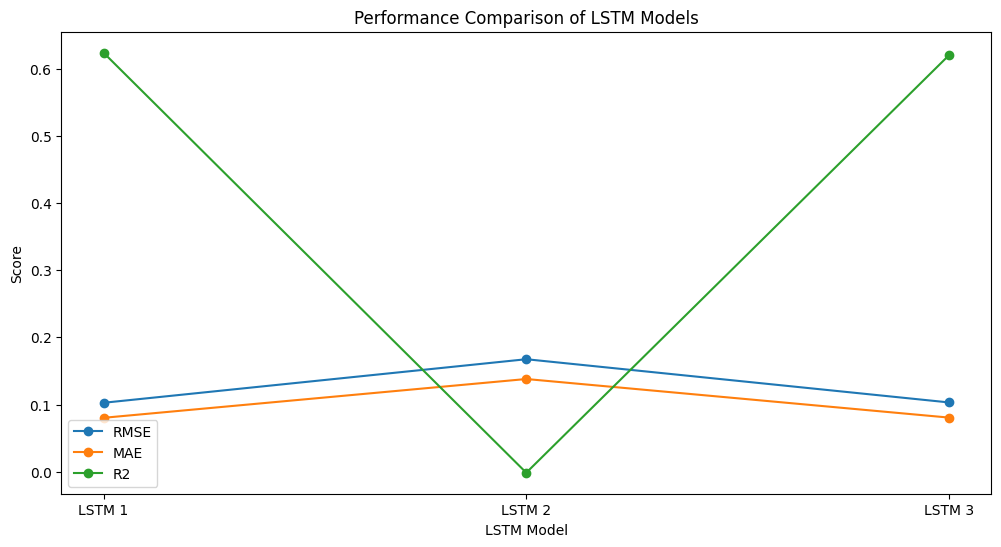

In [249]:
# Optional: Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.xlabel("LSTM Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

### ANN

In [250]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [251]:
# Load data
data = data_autumn  # Assuming data_winter is loaded as a DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1450894011.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_100324\1450894011.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [252]:
# Prepare sequences for time series (Lag of 7 days)
def create_sequences(data, target, sequence_length=7):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        labels.append(target[i + sequence_length])
    return np.array(sequences), np.array(labels)

In [253]:
# Generate sequences and target for training
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=7)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6409, 7, 1)
Shape of y: (6409,)


In [254]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [255]:
# Function to train and evaluate an ANN model
def train_evaluate_ann_model(hidden_units, epochs):
    model = Sequential()
    # Flatten input data to feed into Dense layers
    model.add(Dense(hidden_units[0], activation='relu', input_shape=(X_train.shape[1] * X_train.shape[2],)))
    
    # Add hidden layers based on the configuration
    for units in hidden_units[1:]:
        model.add(Dense(units, activation='relu'))
    
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=Adam(), loss='mse')
    
    # Flatten the input before feeding it to the model
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    # Train the model
    model.fit(X_train_flat, y_train, epochs=epochs, batch_size=16, validation_data=(X_val_flat, y_val), verbose=1)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test_flat)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    
    return rmse, mae, r2

In [256]:
# ANN configurations based on the table provided
ann_configs = [
    {'hidden_units': [6], 'epochs': 104},
    {'hidden_units': [18, 2], 'epochs': 95},
    {'hidden_units': [7, 10, 18], 'epochs': 210}
]

In [257]:
# Train and evaluate each configuration
results = []
for i, config in enumerate(ann_configs):
    rmse, mae, r2 = train_evaluate_ann_model(config['hidden_units'], config['epochs'])
    results.append({'Model': f'ANN {i+1}', 'Hidden Units': config['hidden_units'], 'Epochs': config['epochs'], 'RMSE': rmse, 'MAE': mae, 'R2': r2})

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1/104
257/257 [==============================] - 1s 2ms/step - loss: 0.1857 - val_loss: 0.0325
Epoch 2/104
257/257 [==============================] - 0s 2ms/step - loss: 0.0208 - val_loss: 0.0197
Epoch 3/104
257/257 [==============================] - 0s 2ms/step - loss: 0.0178 - val_loss: 0.0172
Epoch 4/104
257/257 [==============================] - 0s 2ms/step - loss: 0.0161 - val_loss: 0.0157
Epoch 5/104
257/257 [==============================] - 0s 2ms/step - loss: 0.0151 - val_loss: 0.0146
Epoch 6/104
257/257 [==============================] - 0s 2ms/step - loss: 0.0143 - val_loss: 0.0140
Epoch 7/104
257/257 [==============================] - 0s 2ms/step - loss: 0.0138 - val_loss: 0.0134
Epoch 8/104
257/257 [==============================] - 0s 1ms/step - loss: 0.0134 - val_loss: 0.0129
Epoch 9/104
257/257 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0126
Epoch 10/104
257/257 [==============================] - 0s 2ms/step - loss: 0.0129 - val_lo

In [258]:
results_df

,Model,Hidden Units,Epochs,RMSE,MAE,R2
0,ANN 1,[6],104,0.103955,0.081107,0.614292
1,ANN 2,"[18, 2]",95,0.101499,0.079426,0.632299
2,ANN 3,"[7, 10, 18]",210,0.101362,0.078529,0.633290


In [259]:
results_df.to_csv(f'HASIL/ANN_AUTUMN.csv', index=False)

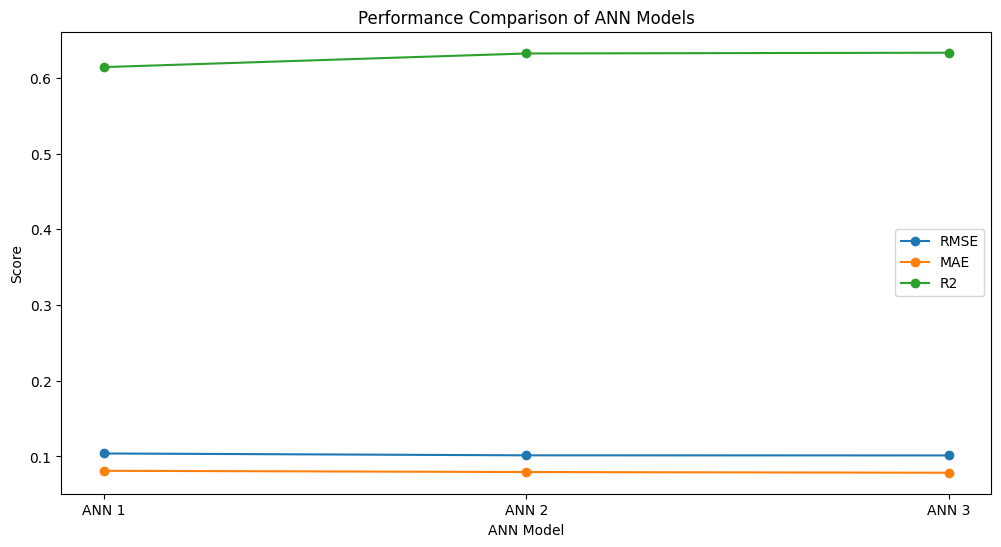

In [260]:
# Optional: Plotting results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.xlabel("ANN Model")
plt.ylabel("Score")
plt.title("Performance Comparison of ANN Models")
plt.legend()
plt.show()

## PREDIKSI 15 HARI

### RNN

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [3]:
# Load data
data = data_autumn  # Pastikan `data_winter` sudah dimuat sebagai DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_87396\3573761752.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_87396\3573761752.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [4]:
def create_sequences(data, target, sequence_length=19, predict_days=15):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        # Create sequence with lag
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        
        # Simulate prediction for the next 15 days (lag of 19)
        labels.append(np.nan)  # Placeholder for actual label (for the time being, we'll calculate it)

        # Simulate prediction: use the average of the last two values in the sequence
        last_two_values = data[i + sequence_length - 2:i + sequence_length]  # Last two values of the sequence
        avg_last_two_values = np.mean(last_two_values)
        
        # Add the simulated prediction to labels (this will be used as the "prediction" for the future)
        labels[-1] = avg_last_two_values
    
    return np.array(sequences), np.array(labels)

In [5]:
# Create sequences and target
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=19)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6397, 19, 1)
Shape of y: (6397,)


In [6]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [7]:
# Function to train and evaluate an RNN model
def train_evaluate_rnn_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            model.add(SimpleRNN(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            model.add(SimpleRNN(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))
    
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    
    return rmse, mae, r2, model

In [8]:
def predict_next_15_days(model, last_sequence, days=15):
    predictions = []
    current_input = last_sequence  # Start with the last available sequence
    
    for _ in range(days):
        # Predict the next day (model expects input in 3D: batch_size, sequence_length, features)
        pred = model.predict(current_input.reshape(1, current_input.shape[0], 1))  # Ensure it's 3D
        
        predictions.append(pred[0, 0])  # Append the scalar prediction value
        
        # Update the sequence by removing the first value and adding the predicted value at the end
        current_input = np.append(current_input[1:], pred)  # Add the predicted value to the sequence
        
        # Ensure the new sequence shape is correct for the next prediction
        current_input = current_input.reshape(-1, 1)  # Keep the sequence 2D for the next iteration
    
    # Rescale the predictions back to the original scale
    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_rescaled

In [9]:
# Define list containing different configurations for evaluation purposes
rnn_configs = [
    {'hidden_units': [3], 'epochs': 292},
    {'hidden_units': [17, 9], 'epochs': 123},
    {'hidden_units': [4, 4, 17], 'epochs': 92}
]
results = []

# Train and evaluate each configuration
for i, config in enumerate(rnn_configs):
    # Train and evaluate the model
    rmse, mae, r2, model = train_evaluate_rnn_model(config['hidden_units'], config['epochs'])
    
    # Append evaluation results to the list
    results.append({
        'Model': f'RNN {i+1}',
        'Hidden Units': config['hidden_units'],
        'Epochs': config['epochs'],
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Model_Object': model  # Save the model object for the best configuration
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("Evaluation Results:")
print(results_df)



Epoch 1/292

256/256 [==============================] - 3s 5ms/step - loss: 4.0459 - val_loss: 0.3461
Epoch 2/292
256/256 [==============================] - 1s 3ms/step - loss: 0.1541 - val_loss: 0.0760
Epoch 3/292
256/256 [==============================] - 1s 4ms/step - loss: 0.0540 - val_loss: 0.0369
Epoch 4/292
256/256 [==============================] - 1s 3ms/step - loss: 0.0278 - val_loss: 0.0206
Epoch 5/292
256/256 [==============================] - 1s 3ms/step - loss: 0.0164 - val_loss: 0.0129
Epoch 6/292
256/256 [==============================] - 1s 3ms/step - loss: 0.0097 - val_loss: 0.0070
Epoch 7/292
256/256 [==============================] - 1s 4ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 8/292
256/256 [==============================] - 1s 4ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 9/292
256/256 [==============================] - 1s 4ms/step - loss: 0.0011 - val_loss: 7.9825e-04
Epoch 10/292
256/256 [==============================] - 1s 3ms/step - loss: 6.0599e-0

In [10]:
results_df

,Model,Hidden Units,Epochs,RMSE,MAE,R2,Model_Object
0,RNN 1,[3],292,0.001859,0.000094,1.000000,<keras.src.engine.sequential.Sequential object...
1,RNN 2,"[17, 9]",123,0.012233,0.008875,0.999994,<keras.src.engine.sequential.Sequential object...
2,RNN 3,"[4, 4, 17]",92,0.012877,0.006826,0.999993,<keras.src.engine.sequential.Sequential object...


In [13]:
results_df.to_csv(f'HASIL/15_RNN_AUTUMN.csv', index=False)

In [11]:
# Select the best model based on RMSE (lowest RMSE indicates best model)
best_model_index = results_df['RMSE'].idxmin()
best_model_info = results_df.iloc[best_model_index]
best_model = best_model_info['Model_Object']  # Retrieve the best model object

print("\nBest Model Configuration:")
print(best_model_info[['Model', 'Hidden Units', 'Epochs', 'RMSE', 'MAE', 'R2']])

# Use the best model to predict the next 15 days
last_sequence = X_test[-1]  # Use the last sequence from the test set
predictions_rescaled = predict_next_15_days(best_model, last_sequence)  # Get 15-day predictions

# Display the predictions
print("\nPredictions for the next 15 days using the best model:")
print(predictions_rescaled.flatten())


Best Model Configuration:
Model              RNN 1
Hidden Units         [3]
Epochs               292
RMSE            0.001859
MAE             0.000094
R2                   1.0
Name: 0, dtype: object
1/1 [==============================] - 0s 27ms/step

Predictions for the next 15 days using the best model:
[18.400013 18.400024 18.400024 18.400028 18.40003  18.400034 18.400038
 18.40004  18.400043 18.400045 18.400051 18.400053 18.400055 18.400059
 18.400063]


In [12]:
predictions_rescaled

array([[18.400013],
       [18.400024],
       [18.400024],
       [18.400028],
       [18.40003 ],
       [18.400034],
       [18.400038],
       [18.40004 ],
       [18.400043],
       [18.400045],
       [18.400051],
       [18.400053],
       [18.400055],
       [18.400059],
       [18.400063]], dtype=float32)

In [14]:
# Ubah menjadi DataFrame
df_predictions = pd.DataFrame(predictions_rescaled, columns=['Predicted_Value'])

In [15]:
df_predictions

,Predicted_Value
0,18.400013
1,18.400024
2,18.400024
3,18.400028
4,18.400030
5,18.400034
6,18.400038
7,18.400040
8,18.400043
9,18.400045


In [16]:
df_predictions.to_csv(f'HASIL_PREDICT/15_RNN_AUTUMN.csv', index=False)

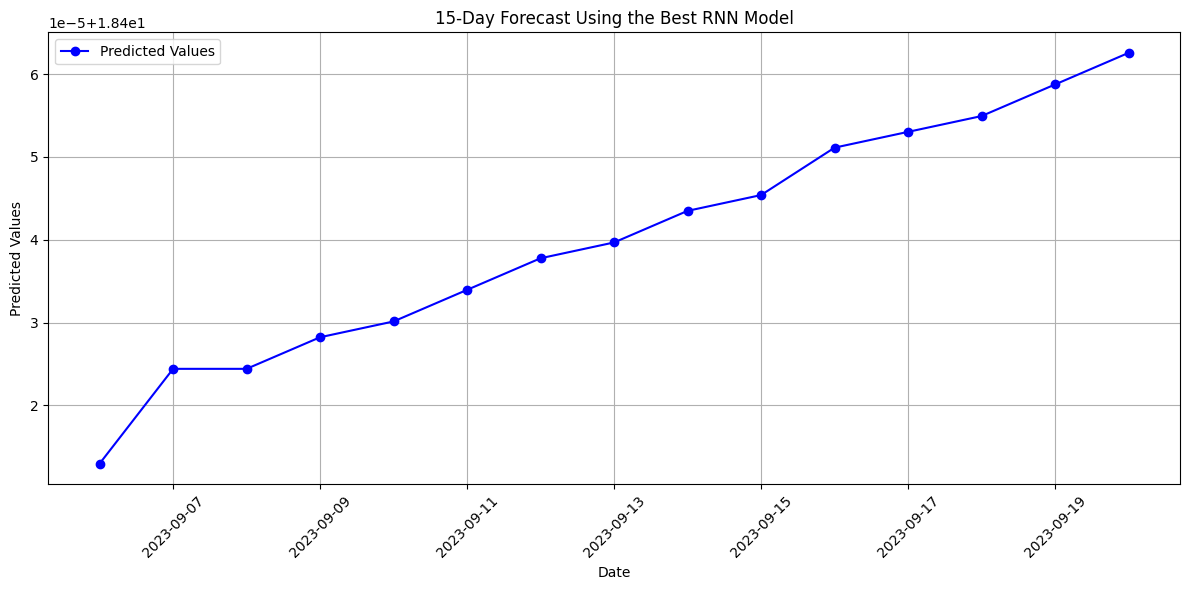

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Generate dates for the next 15 days for plotting purposes
from datetime import timedelta

last_date = pd.to_datetime(data_autumn['date'].iloc[-1])  # Ambil tanggal terakhir dari data asli
future_dates = [last_date + timedelta(days=i) for i in range(1, 16)]

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions_rescaled.flatten(), marker='o', color='b', label='Predicted Values')
plt.title('15-Day Forecast Using the Best RNN Model')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

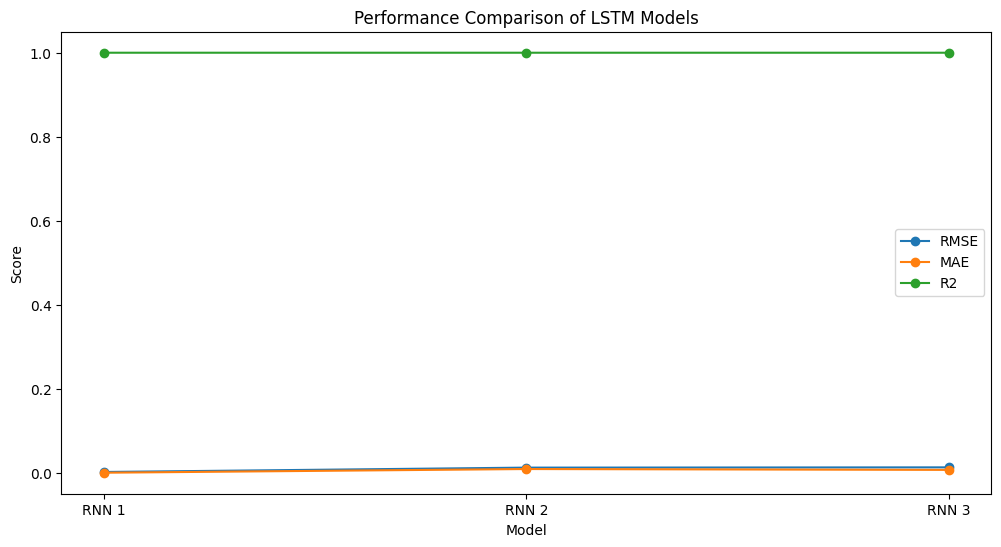

In [19]:
# Optional plotting of results
plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

### LSTM

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [5]:
# Load data
data = data_autumn  # Pastikan `data_winter` sudah dimuat sebagai DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_106408\3573761752.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_106408\3573761752.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [6]:
def create_sequences(data, target, sequence_length=19, predict_days=15):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        # Create sequence with lag
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        
        # Simulate prediction for the next 15 days (lag of 19)
        labels.append(np.nan)  # Placeholder for actual label (for the time being, we'll calculate it)

        # Simulate prediction: use the average of the last two values in the sequence
        last_two_values = data[i + sequence_length - 2:i + sequence_length]  # Last two values of the sequence
        avg_last_two_values = np.mean(last_two_values)
        
        # Add the simulated prediction to labels (this will be used as the "prediction" for the future)
        labels[-1] = avg_last_two_values
    
    return np.array(sequences), np.array(labels)

In [7]:
# Create sequences and target
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=19)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6397, 19, 1)
Shape of y: (6397,)


In [8]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [9]:
def train_evaluate_lstm_model(hidden_units, epochs):
    model = Sequential()
    for i, units in enumerate(hidden_units):
        if i == 0:
            # First LSTM layer with input shape
            model.add(LSTM(units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=(i < len(hidden_units) - 1)))
        else:
            # Subsequent LSTM layers
            model.add(LSTM(units, activation='relu', return_sequences=(i < len(hidden_units) - 1)))
    
    # Output layer
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')
    
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_val, y_val), verbose=1)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    
    # Return RMSE, MAE, R2, and model
    return rmse, mae, r2, model


In [10]:
def predict_next_15_days(model, last_sequence, days=15):
    predictions = []
    current_input = last_sequence  # Start with the last available sequence
    
    for _ in range(days):
        # Predict the next day (model expects input in 3D: batch_size, sequence_length, features)
        pred = model.predict(current_input.reshape(1, current_input.shape[0], 1))  # Ensure it's 3D
        
        predictions.append(pred[0, 0])  # Append the scalar prediction value
        
        # Update the sequence by removing the first value and adding the predicted value at the end
        current_input = np.append(current_input[1:], pred)  # Add the predicted value to the sequence
        
        # Ensure the new sequence shape is correct for the next prediction
        current_input = current_input.reshape(-1, 1)  # Keep the sequence 2D for the next iteration
    
    # Rescale the predictions back to the original scale
    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_rescaled

In [11]:
# Define list containing different configurations for evaluation purposes
lstm_configs = [
    {'hidden_units': [14], 'epochs': 105},
    {'hidden_units': [15, 2], 'epochs': 229},
    {'hidden_units': [12, 7, 4], 'epochs': 111}
]

results = []

# Train and evaluate each configuration
for i, config in enumerate(lstm_configs):
    # Train and evaluate the model
    rmse, mae, r2, model = train_evaluate_lstm_model(config['hidden_units'], config['epochs'])
    
    # Append evaluation results to the list
    results.append({
        'Model': f'LSTM {i+1}',
        'Hidden Units': config['hidden_units'],
        'Epochs': config['epochs'],
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Model_Object': model  # Save the model object for the best configuration
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("Evaluation Results:")
print(results_df)



Epoch 1/105

256/256 [==============================] - 3s 6ms/step - loss: 0.0275 - val_loss: 0.0077
Epoch 2/105
256/256 [==============================] - 1s 6ms/step - loss: 0.0069 - val_loss: 0.0062
Epoch 3/105
256/256 [==============================] - 2s 6ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 4/105
256/256 [==============================] - 1s 6ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 5/105
256/256 [==============================] - 2s 6ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 6/105
256/256 [==============================] - 2s 7ms/step - loss: 0.0010 - val_loss: 8.5603e-04
Epoch 7/105
256/256 [==============================] - 2s 7ms/step - loss: 7.4172e-04 - val_loss: 6.2587e-04
Epoch 8/105
256/256 [==============================] - 1s 5ms/step - loss: 5.7802e-04 - val_loss: 4.9251e-04
Epoch 9/105
256/256 [==============================] - 1s 5ms/step - loss: 4.7824e-04 - val_loss: 4.4768e-04
Epoch 10/105
256/256 [==============================] - 1s 5m

In [12]:
results_df

,Model,Hidden Units,Epochs,RMSE,MAE,R2,Model_Object
0,LSTM 1,[14],105,0.052179,0.037459,0.999890,<keras.src.engine.sequential.Sequential object...
1,LSTM 2,"[15, 2]",229,4.967232,4.060854,-0.000740,<keras.src.engine.sequential.Sequential object...
2,LSTM 3,"[12, 7, 4]",111,0.069072,0.059382,0.999806,<keras.src.engine.sequential.Sequential object...


In [14]:
results_df.to_csv(f'HASIL/15_LSTM_AUTUMN.csv', index=False)

In [13]:
# Select the best model based on RMSE (lowest RMSE indicates best model)
best_model_index = results_df['RMSE'].idxmin()
best_model_info = results_df.iloc[best_model_index]
best_model = best_model_info['Model_Object']  # Retrieve the best model object

print("\nBest Model Configuration:")
print(best_model_info[['Model', 'Hidden Units', 'Epochs', 'RMSE', 'MAE', 'R2']])

# Use the best model to predict the next 15 days
last_sequence = X_test[-1]  # Use the last sequence from the test set
predictions_rescaled = predict_next_15_days(best_model, last_sequence)  # Get 15-day predictions

# Display the predictions
print("\nPredictions for the next 15 days using the best model:")
print(predictions_rescaled.flatten())


Best Model Configuration:
Model             LSTM 1
Hidden Units        [14]
Epochs               105
RMSE            0.052179
MAE             0.037459
R2               0.99989
Name: 0, dtype: object
1/1 [==============================] - 0s 22ms/step

Predictions for the next 15 days using the best model:
[18.422108 18.408241 18.405516 18.398153 18.386354 18.377562 18.367886
 18.358088 18.348429 18.33773  18.327497 18.318295 18.307022 18.298115
 18.286901]


In [15]:
predictions_rescaled

array([[18.422108],
       [18.408241],
       [18.405516],
       [18.398153],
       [18.386354],
       [18.377562],
       [18.367886],
       [18.358088],
       [18.348429],
       [18.33773 ],
       [18.327497],
       [18.318295],
       [18.307022],
       [18.298115],
       [18.286901]], dtype=float32)

In [16]:
# Ubah menjadi DataFrame
df_predictions = pd.DataFrame(predictions_rescaled, columns=['Predicted_Value'])

In [17]:
df_predictions

,Predicted_Value
0,18.422108
1,18.408241
2,18.405516
3,18.398153
4,18.386354
5,18.377562
6,18.367886
7,18.358088
8,18.348429
9,18.337730


In [18]:
df_predictions.to_csv(f'HASIL_PREDICT/15_LSTM_AUTUMN.csv', index=False)

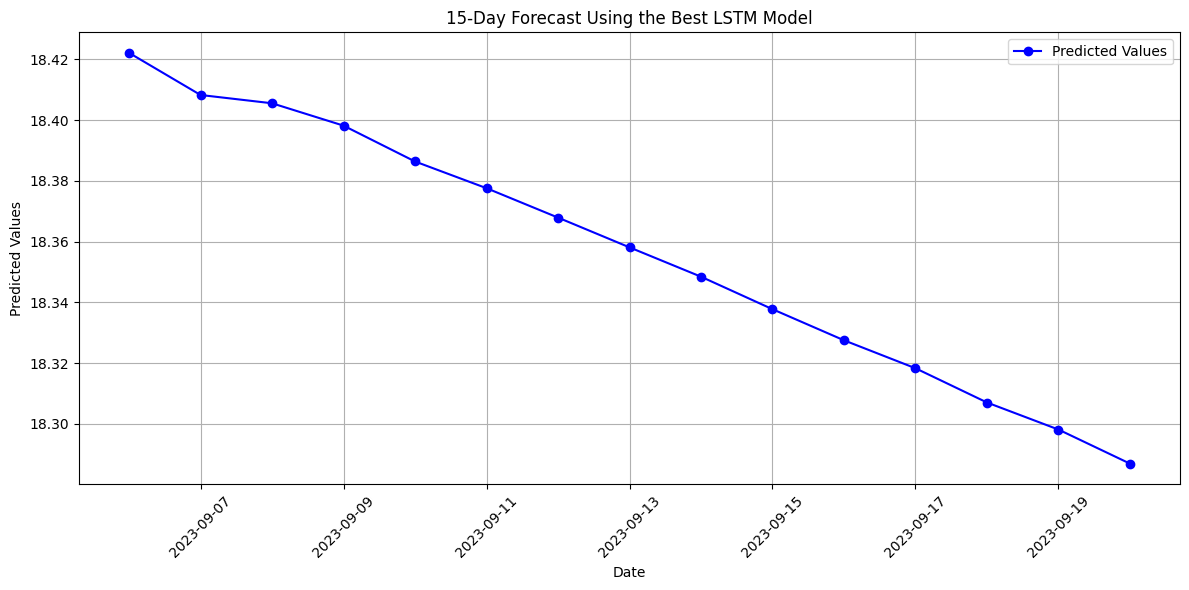

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Generate dates for the next 15 days for plotting purposes
from datetime import timedelta

last_date = pd.to_datetime(data_autumn['date'].iloc[-1])  # Ambil tanggal terakhir dari data asli
future_dates = [last_date + timedelta(days=i) for i in range(1, 16)]

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions_rescaled.flatten(), marker='o', color='b', label='Predicted Values')
plt.title('15-Day Forecast Using the Best LSTM Model')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

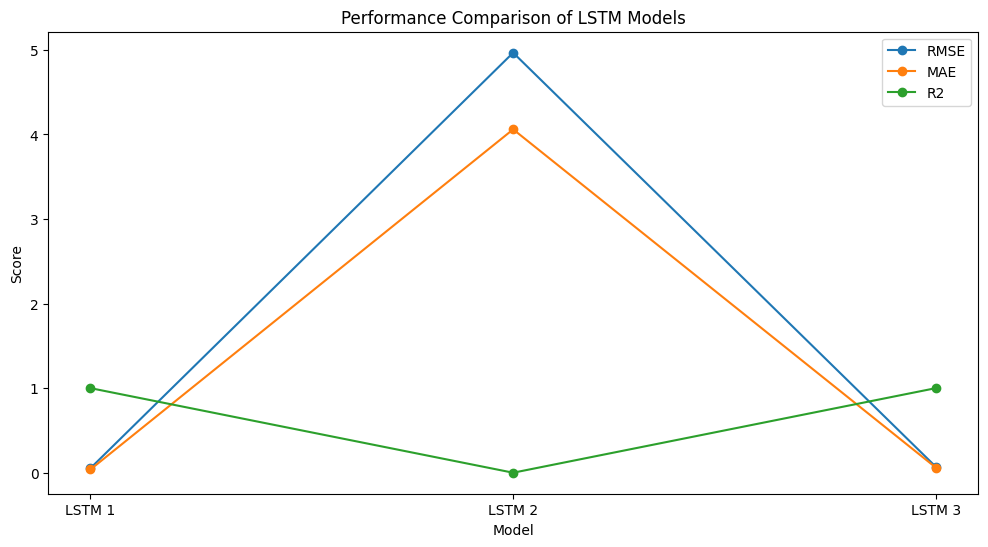

In [21]:
# Optional plotting of results
plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

### ANN

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [3]:
# Load data
data = data_autumn  # Pastikan `data_winter` sudah dimuat sebagai DataFrame

# Handle missing values by forward filling or other imputation methods
data['max_temp_c'].fillna(method='ffill', inplace=True)

# Normalize the max_temp_c values
scaler = MinMaxScaler()
data['max_temp_c'] = scaler.fit_transform(data[['max_temp_c']])

C:\Users\proda\AppData\Local\Temp\ipykernel_93928\3573761752.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['max_temp_c'].fillna(method='ffill', inplace=True)
C:\Users\proda\AppData\Local\Temp\ipykernel_93928\3573761752.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['max_temp_c'].fillna(method='ffill', inplace=True)


In [4]:
def create_sequences(data, target, sequence_length=25, predict_days=15):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        # Create sequence with lag
        sequences.append(data[i:i + sequence_length].reshape(-1, 1))  # Reshape to (sequence_length, 1)
        
        # Simulate prediction for the next 15 days (lag of 25)
        labels.append(np.nan)  # Placeholder for actual label (for the time being, we'll calculate it)

        # Simulate prediction: use the average of the last two values in the sequence
        last_two_values = data[i + sequence_length - 2:i + sequence_length]  # Last two values of the sequence
        avg_last_two_values = np.mean(last_two_values)
        
        # Add the simulated prediction to labels (this will be used as the "prediction" for the future)
        labels[-1] = avg_last_two_values
    
    return np.array(sequences), np.array(labels)

In [5]:
# Create sequences and target
X, y = create_sequences(data['max_temp_c'].values, data['max_temp_c'].values, sequence_length=25)

# Check shapes of X and y
print("Shape of X:", X.shape)  # Should be (num_samples, sequence_length, 1)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (6391, 25, 1)
Shape of y: (6391,)


In [6]:
# Split the data: 80% training and 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [7]:
# Function to train and evaluate an ANN model
def train_evaluate_ann_model(hidden_units, epochs):
    model = Sequential()
    # Flatten input data to feed into Dense layers
    model.add(Dense(hidden_units[0], activation='relu', input_shape=(X_train.shape[1] * X_train.shape[2],)))
    
    # Add hidden layers based on the configuration
    for units in hidden_units[1:]:
        model.add(Dense(units, activation='relu'))
    
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=Adam(), loss='mse')
    
    # Flatten the input before feeding it to the model
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    # Train the model
    model.fit(X_train_flat, y_train, epochs=epochs, batch_size=16, validation_data=(X_val_flat, y_val), verbose=1)
    
    # Evaluate the model on the test set
    y_pred = model.predict(X_test_flat)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)
    
    return rmse, mae, r2, model

In [8]:
last_sequence = X_test[-1].reshape(1, -1)

In [9]:
def predict_next_15_days(model, last_sequence, days=15):
    predictions = []
    current_input = last_sequence.flatten()  # Flatten the sequence to match the training input

    for _ in range(days):
        # Predict the next day using the flattened input
        pred = model.predict(current_input.reshape(1, -1))  # Ensure it's 2D as expected by the model
        
        predictions.append(pred[0, 0])  # Append the scalar prediction value
        
        # Update the sequence by removing the first value and adding the predicted value at the end
        current_input = np.append(current_input[1:], pred)  # Keep sequence 1D to match the model input
        
    # Rescale the predictions back to the original scale
    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return predictions_rescaled


In [10]:
# Define list containing different configurations for evaluation purposes
ann_configs = [
    {'hidden_units': [6], 'epochs': 104},
    {'hidden_units': [18, 2], 'epochs': 95},
    {'hidden_units': [7, 10, 18], 'epochs': 210}
]

results = []

# Train and evaluate each configuration
for i, config in enumerate(ann_configs):
    # Train and evaluate the model
    rmse, mae, r2, model = train_evaluate_ann_model(config['hidden_units'], config['epochs'])
    
    # Append evaluation results to the list
    results.append({
        'Model': f'ANN {i+1}',
        'Hidden Units': config['hidden_units'],
        'Epochs': config['epochs'],
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Model_Object': model  # Save the model object for the best configuration
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("Evaluation Results:")
print(results_df)



Epoch 1/104

256/256 [==============================] - 1s 3ms/step - loss: 0.1004 - val_loss: 0.0209
Epoch 2/104
256/256 [==============================] - 1s 2ms/step - loss: 0.0187 - val_loss: 0.0167
Epoch 3/104
256/256 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0121
Epoch 4/104
256/256 [==============================] - 1s 2ms/step - loss: 0.0100 - val_loss: 0.0081
Epoch 5/104
256/256 [==============================] - 1s 2ms/step - loss: 0.0065 - val_loss: 0.0053
Epoch 6/104
256/256 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0033
Epoch 7/104
256/256 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 8/104
256/256 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 9/104
256/256 [==============================] - 1s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 10/104
256/256 [==============================] - 1s 2ms/step - loss: 0.0011 - val_

In [11]:
results_df

,Model,Hidden Units,Epochs,RMSE,MAE,R2,Model_Object
0,ANN 1,[6],104,0.016856,0.007462,0.999990,<keras.src.engine.sequential.Sequential object...
1,ANN 2,"[18, 2]",95,0.012213,0.006871,0.999995,<keras.src.engine.sequential.Sequential object...
2,ANN 3,"[7, 10, 18]",210,0.049739,0.007797,0.999909,<keras.src.engine.sequential.Sequential object...


In [13]:
results_df.to_csv(f'HASIL/15_ANN_AUTUMN.csv', index=False)

In [12]:
# Select the best model based on RMSE (lowest RMSE indicates best model)
best_model_index = results_df['RMSE'].idxmin()
best_model_info = results_df.iloc[best_model_index]
best_model = best_model_info['Model_Object']  # Retrieve the best model object

print("\nBest Model Configuration:")
print(best_model_info[['Model', 'Hidden Units', 'Epochs', 'RMSE', 'MAE', 'R2']])

# Use the best model to predict the next 15 days
last_sequence = X_test[-1]  # Use the last sequence from the test set
predictions_rescaled = predict_next_15_days(best_model, last_sequence)  # Get 15-day predictions

# Display the predictions
print("\nPredictions for the next 15 days using the best model:")
print(predictions_rescaled.flatten())


Best Model Configuration:
Model              ANN 2
Hidden Units     [18, 2]
Epochs                95
RMSE            0.012213
MAE             0.006871
R2              0.999995
Name: 1, dtype: object
1/1 [==============================] - 0s 26ms/step

Predictions for the next 15 days using the best model:
[29.311092 30.267143 29.790794 30.031881 29.916449 29.975605 29.94057
 29.945448 29.936916 29.935322 29.925358 29.921745 29.919437 29.914797
 29.910011]


In [14]:
predictions_rescaled

array([[29.311092],
       [30.267143],
       [29.790794],
       [30.031881],
       [29.916449],
       [29.975605],
       [29.94057 ],
       [29.945448],
       [29.936916],
       [29.935322],
       [29.925358],
       [29.921745],
       [29.919437],
       [29.914797],
       [29.910011]], dtype=float32)

In [15]:
# Ubah menjadi DataFrame
df_predictions = pd.DataFrame(predictions_rescaled, columns=['Predicted_Value'])

In [16]:
df_predictions

,Predicted_Value
0,29.311092
1,30.267143
2,29.790794
3,30.031881
4,29.916449
5,29.975605
6,29.940571
7,29.945448
8,29.936916
9,29.935322


In [17]:
df_predictions.to_csv(f'HASIL_PREDICT/15_ANN_AUTUMN.csv', index=False)

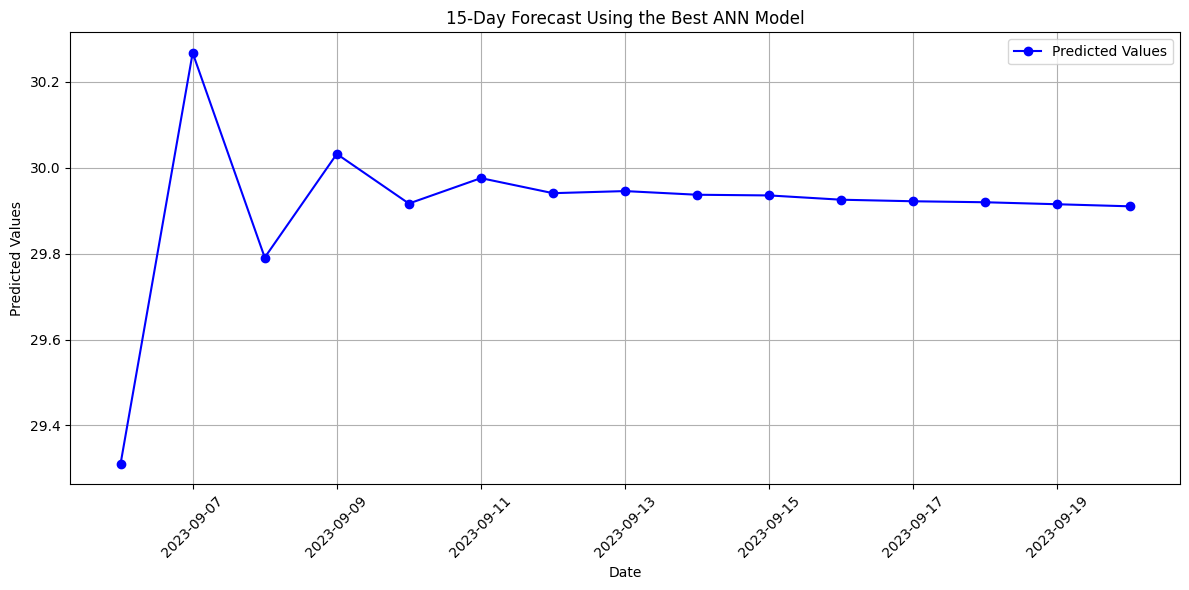

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Generate dates for the next 15 days for plotting purposes
from datetime import timedelta

last_date = pd.to_datetime(data_autumn['date'].iloc[-1])  # Ambil tanggal terakhir dari data asli
future_dates = [last_date + timedelta(days=i) for i in range(1, 16)]

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions_rescaled.flatten(), marker='o', color='b', label='Predicted Values')
plt.title('15-Day Forecast Using the Best ANN Model')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

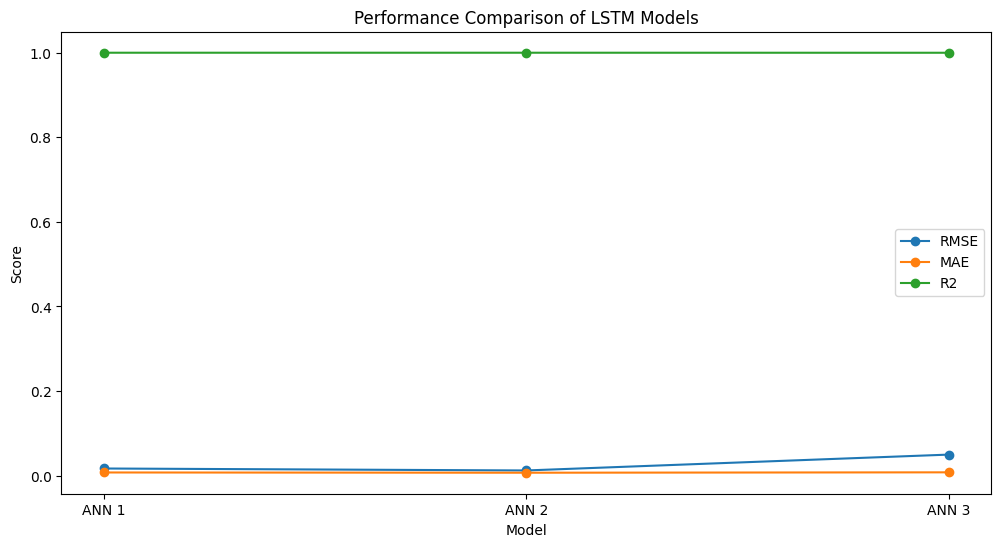

In [20]:
# Optional plotting of results
plt.figure(figsize=(12, 6))
for metric in ['RMSE', 'MAE', 'R2']:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Performance Comparison of LSTM Models")
plt.legend()
plt.show()

Average day-to-day change in predictions: 0.13738741
Standard deviation of day-to-day changes in predictions: 0.29176253

Day-to-day changes for each predicted day:
    Day  Day-to-Day Change
0     1           0.956051
1     2          -0.476349
2     3           0.241087
3     4          -0.115433
4     5           0.059156
5     6          -0.035034
6     7           0.004877
7     8          -0.008532
8     9          -0.001595
9    10          -0.009964
10   11          -0.003613
11   12          -0.002308
12   13          -0.004641
13   14          -0.004786


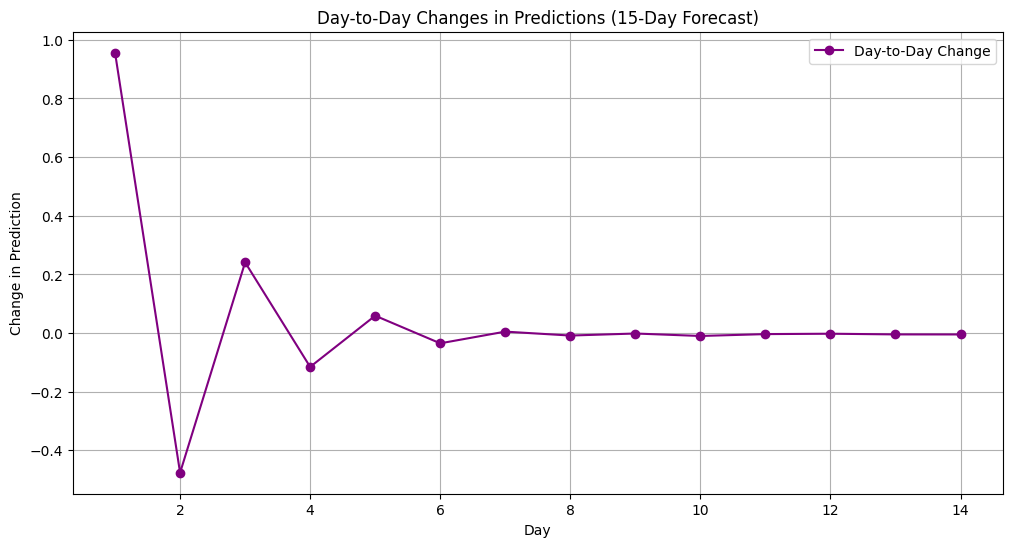

In [21]:
# Calculate differences between consecutive predictions
predicted_differences = np.diff(predictions_rescaled.flatten())

# Convert to DataFrame for better readability
df_predicted_differences = pd.DataFrame({
    'Day': range(1, 15),  # We have 14 differences for 15 predictions
    'Day-to-Day Change': predicted_differences
})

# Calculate statistics on the changes to understand prediction stability
avg_day_to_day_change = np.mean(np.abs(predicted_differences))
std_day_to_day_change = np.std(predicted_differences)

print("Average day-to-day change in predictions:", avg_day_to_day_change)
print("Standard deviation of day-to-day changes in predictions:", std_day_to_day_change)
print("\nDay-to-day changes for each predicted day:")
print(df_predicted_differences)

# Plot day-to-day changes
plt.figure(figsize=(12, 6))
plt.plot(df_predicted_differences['Day'], df_predicted_differences['Day-to-Day Change'], marker='o', color='purple', label='Day-to-Day Change')
plt.xlabel('Day')
plt.ylabel('Change in Prediction')
plt.title('Day-to-Day Changes in Predictions (15-Day Forecast)')
plt.legend()
plt.grid(True)
plt.show()